Let's test calculating vertical heat flux as prescribed in Su et Al., 2020

(Su, Z., Torres, H., Klein, P., Thompson, A. F., Siegelman, L., Wang, J., et al. (2020). High‐frequency submesoscale motions enhance the upward vertical heat transport in the global ocean. Journal of Geophysical Research:  Oceans, 125, e2020JC016544. https:// doi.org/10.1029/2020JC016544)

SOME NOTES:
<W'T'> = bar(WT) - bar(W) bar(T)\
expand to 1 deg by 1 deg boxes for full meso inclusion
could diagnose meso by expanding time avg from 1 day to 7 days


The following are the exact steps utilized in this notebook to explore vertical heat flux calculations:
1. define W (vertical velocity) and T (Theta, potential temperature) within a 1 deg x 1 deg box centered at 39N, 158E in the LLC4320 dataset. Split into 4 0.5 deg x 0.5 deg sub-boxes.
2. interpolate W using grid_3d.interp along the z axis. This is necessary as Theta values are spatially centered within LLC pixels while W (vertical velocity) values are horizontally centered, but vertically shifted to the edges of LLC pixels.
3. define half-deg sub-boxes, coarse grain the means spatially in each 0.5 x 0.5 box at each hourly time t 
4. calculate the total VHF with $C_p \rho <W'T'>$ for each time t, where\
<W'T'> = bar(WT) - bar(W) bar(T)
5. apply a Hann window to reduce spectral leakage -- explore VHF calculated from both $<W'T'>$ and $<W'T'>_{window}$
6. take the temporal fourier transform of the hann window of <W'T'> to produce $<W'T'>_{window}$
7. define LF and HF by respectively applying a low and high pass filter to <W'T'> using a mask and inverse fourier transform back into time space
8. define LF and HF VHF respectively with $C_p \rho W_{lowpass} T_{lowpass}$ and $C_p \rho W_{highpass} T_{highpass}$
9. explore visualizations of VHF

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import Affine2D

(np.float64(-0.5), np.float64(4099.5), np.float64(1298.5), np.float64(-0.5))

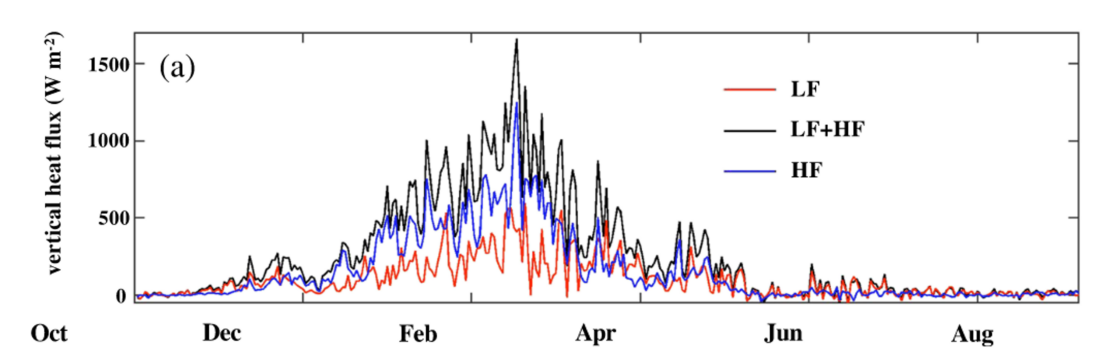

In [2]:
plt.figure(figsize=(14,8))
plt.imshow(plt.imread('su_fig_5_kuroshio.png'))
plt.axis('off')

Let's replicate a portion of this figure:
Figure 5. Time series of vertical heat flux associated with scales <0.5° at 40‐m depth. Curves indicate heat fluxes calculated from daily mean model output (red, low‐frequency or LF), hourly snapshots (black, low‐frequency + highfrequency, or LF + HF), and the difference between the two (blue, high‐frequency or HF). The LF + HF time series have been daily averaged for easier comparison. Heat flux calculations are from a 1° × 1° box centered at a given location in each region. Panels (a) to (e), respectively, refer to the Kuroshio Extension (box centered at 39°N, 158°E), the Gulf Stream (box centered at 39°N, 66°W), (b) Northernmost Atlantic (box centered at 58°N, 24°W), (c) Agulhas Current (box centered at 43°S, 14°E), and (d) the Southern Ocean (box centered at 50°S, 87°E).

In [3]:
import xarray as xr
import numpy as np
import dask
import zarr
import xgcm 
import xrft
from scipy.signal import butter

In [4]:
t_0 =  0 #4000
t_1 =  int(429 * 24 / 2)# t_0 +  24 * 4 * 4#
i_0 = 2790
i_1 = 2860
j_0 = 745
j_1 = 795

slice(t_0,t_1)
# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face 7, temporal subset, chunk
LLC_sub = LLC_full.isel(time = slice(t_0,t_1), \
    i = slice(i_0, i_1), j = slice(j_0, j_1), \
        face = 7).chunk({'time': -1, 'i': -1, 'j': -1})

0. Open LLC

In [5]:
# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [6]:
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

In [7]:
LLC_sub

<xarray.Dataset> Size: 578GB
Dimensions:   (time: 5148, j: 50, i: 70, i_g: 4320, k: 51, j_g: 4320, k_l: 51,
               k_p1: 52, k_u: 51)
Coordinates:
  * i         (i) int16 140B 2790 2791 2792 2793 2794 ... 2856 2857 2858 2859
  * j_g       (j_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j         (j) int16 100B 745 746 747 748 749 750 ... 789 790 791 792 793 794
  * i_g       (i_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * k_u       (k_u) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 41kB 2011-09-13 ... 2012-04-14T11:00:00
  * k_l       (k_l) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
    face      int16 2B 7
  * k         (k) int16 102B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_p1      (k_p1) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
Data variables: (12/55)
    SIarea    (time, j, i) float32 72MB dask.array<chunksize=(5148, 50, 70), meta=np.ndarray>
    dyG       (j, i_g) float32 864kB dask.array<chunksize=(50, 720), meta=np.ndarray>
    Depth     (j, i) float32 14kB dask.array<chunksize=(50, 70), meta=np.ndarray>
    hFacS     (k, j_g, i) float32 62MB dask.array<chunksize=(51, 720, 70), meta=np.ndarray>
    PHrefC    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Zl        (k_l) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    ...        ...
    oceQnet   (time, j, i) float32 72MB dask.array<chunksize=(5148, 50, 70), meta=np.ndarray>
    dxF       (j, i) float32 14kB dask.array<chunksize=(50, 70), meta=np.ndarray>
    SIvice    (time, j_g, i) float32 6GB dask.array<chunksize=(5148, 4320, 70), meta=np.ndarray>
    rhoRef    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Eta       (time, j, i) float32 72MB dask.array<chunksize=(5148, 50, 70), meta=np.ndarray>
    PHrefF    (k_p1) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>

In [8]:
# redefine LLC_sub without k selection for interpolation
# i_0 = 2615 # 5 deg
# i_1 = 2965
# j_0 = 620
# j_1 = 870

# i_0 = 2755 #2 deg
# i_1 = 2895
# j_0 = 720
# j_1 = 820

i_0 = 2790 #1 deg
i_1 = 2860
j_0 = 745
j_1 = 795

LLC_sub = LLC_full.isel(i = slice(i_0, i_1), j = slice(j_0, j_1), face = 7)

# select temporal subset for testing-----
days = 2
t_0 = 4000
t_1 = t_0 + days * 24
LLC_sub = LLC_sub.isel(time = slice(t_0, t_1)).chunk({'time': -1, 'i': -1, 'j': -1})

In [9]:
# define and interpolate vertical velocity
grid_3d = xgcm.Grid(
    LLC_sub,
    coords={
        'Z': {'center': 'k', 'left': 'k_p1'}},
    autoparse_metadata=False)

LLC_sub['W_interp'] = grid_3d.interp(LLC_sub['W'], 'Z', boundary='extend')

LLC_sub = LLC_sub.isel(k=14)

In [10]:
# function to select i-j slices per box by lat/lon boxes
def i_j_slices(LLC, spacing):
    i_start, i_end = [], []
    j_start, j_end = [], []

    XC, YC= LLC['XC'].values, LLC['YC'].values

  #  i_min, j_min = np.min(LLC['i'].values), np.min(LLC['j'].values)

    extent = (np.nanmax(XC)) - (np.nanmin(XC))
    num_boxes = extent/spacing 

    lon_min, lat_min= np.nanmin(XC), np.nanmin(YC)

    for box in range(int(num_boxes)):
        # start lat/lon
        lon_start, lat_start = lon_min + spacing * box, lat_min + spacing * box

        # end lat/lon
        lon_end, lat_end = lon_min + spacing * box + spacing, lat_min + spacing * box + spacing

        # convert to i,j
        lon_dist_s, lat_dist_s = np.nanargmin(np.abs(XC - lon_start)),  np.nanargmin(np.abs(YC - lat_start))
        (_,i_s), (j_s,_) = np.unravel_index(lat_dist_s, YC.shape), np.unravel_index(lon_dist_s, XC.shape)

        lon_dist_e, lat_dist_e = np.nanargmin(np.abs(XC - lon_end)),  np.nanargmin(np.abs(YC - lat_end))
        (_,i_e), (j_e,_) = np.unravel_index(lat_dist_e, YC.shape), np.unravel_index(lon_dist_e, XC.shape)


        i_start.append(int(i_e)), i_end.append(int(i_s)), j_start.append(int(j_s)), j_end.append(int(j_e))
   # print (f'i: {i_start[::-1]}, {i_end[::-1]}, j: {j_start}, {j_end}, {int(num_boxes)}')
    return i_start[::-1], i_end[::-1], j_start, j_end, int(num_boxes)


def iterate_boxes(LLC, resolution_deg):

    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, resolution_deg)

    box_id = 0
    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):
            # only yield boxes with valid size
            if (i1 - i0) > 0 and (j1 - j0) > 0:
                yield box_id, (i0, i1, j0, j1)
                box_id += 1
                
# function to build a box index
def build_sub_index(LLC, resolution_deg,type):
    box = xr.full_like(LLC["XC"], fill_value=-1).astype(int)
    box = box.rename([type])

    for box_id, (i0, i1, j0, j1) in iterate_boxes(LLC, resolution_deg):
        box[j0:j1, i0:i1] = box_id
    return box

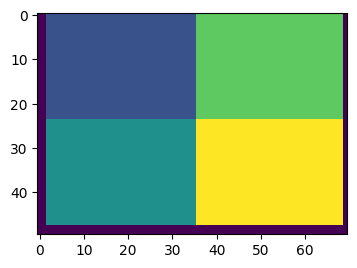

In [11]:
# build tile index
tile_width= 0.5
tile_index = build_sub_index(LLC_sub, tile_width,"tile").compute()
LLC_sub = LLC_sub.assign_coords(tile=tile_index)
# mask invalid pixels (the purple edges in the fig below)
LLC_sub = LLC_sub.where(LLC_sub.tile >= 0)
plt.figure(figsize=(4,6))
plt.imshow(tile_index)

In [21]:
W = LLC_sub['W_interp']
T = LLC_sub['Theta']
A = LLC_sub['rA']

# trim
valid = W.tile != -1
W = W.where(valid)
T = T.where(valid)
A = A.where(valid)


"""
5. coarse grain spatially
"""

# define WT_m, W_m, T_m, weighting by surface cell areas

WT_m = ((W * T * A).groupby("tile").sum() / A.groupby("tile").sum())
W_m = ((W * A).groupby("tile").sum() / A.groupby("tile").sum())
T_m = ((T * A).groupby("tile").sum() / A.groupby("tile").sum())


"""
6. calculate the total VHF with $C_p \rho <W'T'>$ for each time t, where <W'T'> = bar(WT) - bar(W) bar(T)
"""

# calculate <W'T'>, avg by tile
C_p, rho = 3900, 1025
total_WT_ = (WT_m.mean(dim="tile") - (W_m.mean(dim="tile") * T_m.mean(dim="tile")))

VHF_total = C_p * rho * total_WT_

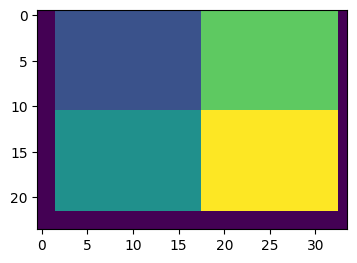

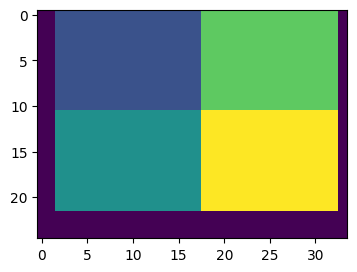

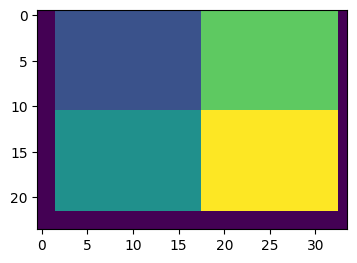

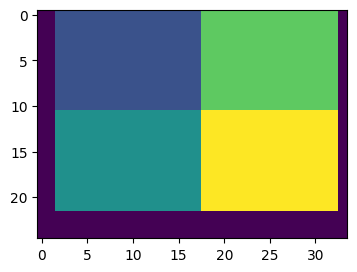

In [10]:
"""
7. loop over each tile, take the temporal fourier transform of W and T fields, calculate VHF
"""

# define filter cutoff
dt = 1.0
LF_cutoff = 24 * 3
fc = dt / LF_cutoff
Nt = LLC_sub.sizes['time']
freq = np.fft.fftfreq(Nt, d=dt)

LF_mask = (abs(freq) <= fc)
HF_mask = (abs(freq) > fc)

# expand dims for broadcasting: (Nt, 1, 1)
LF_mask_nd = LF_mask[:, None, None]
HF_mask_nd = HF_mask[:, None, None]

# define heat capacity and density
C_p = 3900
rho = 1025

# loop over each tile, calculate VHF
LF_VHF_list = []
HF_VHF_list = []
total_VHF_sum_list = []
for tile in np.unique(LLC_sub.tile.values):
    if tile >= 0:
        # select current tile
        LLC_tile = LLC_sub.where(LLC_sub.tile == tile, drop=True)

        # break tile into sub-boxes
        box_width = 0.23
        box_index = build_sub_index(LLC_tile, box_width,"box").compute()
        LLC_tile = LLC_tile.assign_coords(box=box_index)
        # mask invalid pixels
        LLC_tile = LLC_tile.where(LLC_tile.box >= 0)
        plt.figure(figsize=(4,6))
        plt.imshow(box_index)  
        
        # define W, T, A
        W = LLC_tile['W_interp']
        T = LLC_tile['Theta']
        A = LLC_tile['rA']

        # trim
        valid = W.box != 1
        W = W.where(valid)
        T = T.where(valid)
        A = A.where(valid)

        # take the temporal fft of the W and T fields
        time_axis = W.get_axis_num("time")
        W_f = np.fft.fft(W.data, axis=time_axis)
        T_f = np.fft.fft(T.data, axis=time_axis)

        # apply masks (broadcasts over i,j)
        LF_W = W_f * LF_mask_nd
        HF_W = W_f * HF_mask_nd

        LF_T = T_f * LF_mask_nd
        HF_T = T_f * HF_mask_nd

        # inverse fourier transform back into time space, take the real
        W_LF = np.fft.ifft(LF_W, axis=time_axis).real
        W_HF = np.fft.ifft(HF_W, axis=time_axis).real 

        T_LF = np.fft.ifft(LF_T, axis=time_axis).real
        T_HF = np.fft.ifft(HF_T, axis=time_axis).real 

        # return to xarray
        coords = {"time": W.time, "i": W.i, "j": W.j}
        dims = ("time", "j", "i")
        
        W_LF = xr.DataArray(W_LF, coords=coords, dims=dims, name="W_LF")
        W_HF = xr.DataArray(W_HF, coords=coords, dims=dims, name="W_HF")

        T_LF = xr.DataArray(T_LF, coords=coords, dims=dims, name="T_LF")
        T_HF = xr.DataArray(T_HF, coords=coords, dims=dims, name="T_HF")

        # define WT, Wm, Tm, weighting by surface cell areas
        # LF
        WT_LF = (W_LF * T_LF * A).groupby("box").sum() / A.groupby("box").sum()
        Wm_LF = (W_LF * A).groupby("box").sum() / A.groupby("box").sum()
        Tm_LF = (T_LF * A).groupby("box").sum() / A.groupby("box").sum()

        # HF
        WT_HF = (W_HF * T_HF * A).groupby("box").sum() / A.groupby("box").sum()
        Wm_HF = (W_HF * A).groupby("box").sum() / A.groupby("box").sum()
        Tm_HF = (T_HF * A).groupby("box").sum() / A.groupby("box").sum()

        # define VHF
        LF_VHF =  C_p * rho * (WT_LF.mean(dim="box") - Wm_LF.mean(dim="box") * Tm_LF.mean(dim="box"))
        HF_VHF =  C_p * rho * (WT_HF.mean(dim="box") - Wm_HF.mean(dim="box") * Tm_HF.mean(dim="box"))
        VHF_total_sum = LF_VHF + HF_VHF

        # append VHF to lists
        LF_VHF_list.append(LF_VHF)
        HF_VHF_list.append(HF_VHF)
        total_VHF_sum_list.append(VHF_total_sum)

# concat lists together
LF_VHF = xr.concat(LF_VHF_list, dim="tile").mean("tile")
HF_VHF = xr.concat(HF_VHF_list, dim="tile").mean("tile")
total_VHF_sum = xr.concat(total_VHF_sum_list, dim="tile").mean("tile")

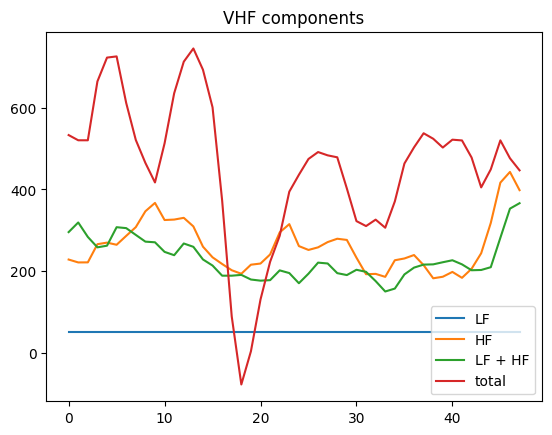

In [11]:
plt.plot(LF_VHF, label = 'LF')
plt.plot(HF_VHF, label = 'HF')
plt.plot(VHF_total_sum, label = 'LF + HF')
plt.plot(VHF_total, label='total')
plt.title('VHF components')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# define filter cutoff
dt = 1.0
LF_cutoff = 24 
fc = dt / LF_cutoff
Nt = W_pix.sizes['time']
freq = np.fft.fftfreq(Nt, d=dt)

LF_mask = (abs(freq) <= fc)
HF_mask = (abs(freq) > fc)

# define heat capacity and density
C_p = 3900
rho = 1025

# loop over each tile, calculate VHF
LF_VHF_list = []
HF_VHF_list = []
for tile in np.unique(W_pix.box.values > 0):
    Wb = W_pix.where(W_pix.box == tile, drop=True)
    Tb = T_pix.where(T_pix.box == tile, drop=True)
    Ab = A_pix.where(A_pix.box == tile, drop=True)

    # FFT in time
    W_f = np.fft.fft(Wb.data , axis=0) # .data because ufunc doesn't support xarray objects 
    T_f = np.fft.fft(Tb.data, axis=0)

    # apply freq masks
    LF_Wf = W_f * LF_mask[:, None]
    HF_Wf = W_f * HF_mask[:, None]

    LF_Tf = T_f * LF_mask[:, None]
    HF_Tf = T_f * HF_mask[:, None]

    # IFFT
    W_LF = np.fft.ifft(LF_Wf, axis=0).real
    T_LF = np.fft.ifft(LF_Tf, axis=0).real

    W_HF = np.fft.ifft(HF_Wf, axis=0).real
    T_HF = np.fft.ifft(HF_Tf, axis=0).real

    # return to xarray
    coords = {"time": Wb.time, "pix": Wb.pix}
    dims = ("time", "pix")
    
    W_LF = xr.DataArray(W_LF, coords=coords, dims=dims, name="W_LF")
    W_HF = xr.DataArray(W_HF, coords=coords, dims=dims, name="W_HF")

    T_LF = xr.DataArray(T_LF, coords=coords, dims=dims, name="T_LF")
    T_HF = xr.DataArray(T_HF, coords=coords, dims=dims, name="T_HF")


    # group into boxes, define Wt, Wm, Tm, weighting by surface cell areas
    

#     # area-weighted <W'T'> = bar(WT) - bar(W) bar(T)
#     WT_LF = (W_LF * T_LF * Ab).sum("pix") / Ab.sum("pix")
#     WT_HF = (W_HF * T_HF * Ab).sum("pix") / Ab.sum("pix")

#     Wm_LF = (W_LF * Ab).sum("pix") / Ab.sum("pix")
#     Tm_LF = (T_LF * Ab).sum("pix") / Ab.sum("pix")

#     Wm_HF = (W_HF * Ab).sum("pix") / Ab.sum("pix")
#     Tm_HF = (T_HF * Ab).sum("pix") / Ab.sum("pix")

#     LF_VHF_list.append(C_p * rho * (WT_LF - Wm_LF * Tm_LF))
#     HF_VHF_list.append(C_p * rho * (WT_HF - Wm_HF * Tm_HF))

# LF_VHF = xr.concat(LF_VHF_list, dim="box").mean("box")
# HF_VHF = xr.concat(HF_VHF_list, dim="box").mean("box")

# VHF_total_sum = LF_VHF + HF_VHF

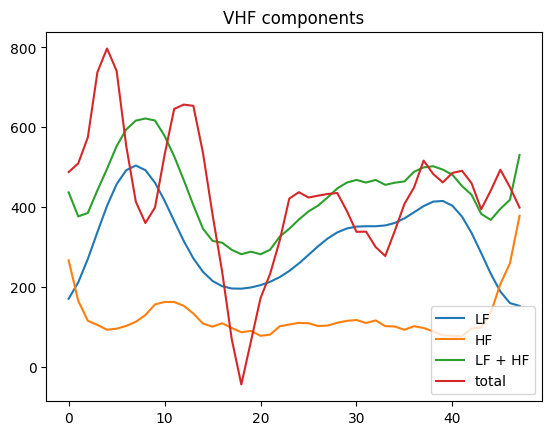

In [14]:
plt.plot(LF_VHF, label = 'LF')
plt.plot(HF_VHF, label = 'HF')
plt.plot(VHF_total_sum, label = 'LF + HF')
plt.plot(VHF_total, label='total')
plt.title('VHF components')
plt.legend(loc = 'lower right')
plt.show()

In [18]:
# build i,j,face index for a lat/lon spatial box about central lat/lon coord for llc4320
def llc_latlon_box_indices(
    LLC,
    lat_center,
    lon_center,
    degree_extent
):

    half = degree_extent / 2.0

    lat_min = lat_center - half
    lat_max = lat_center + half
    lon_min = lon_center - half
    lon_max = lon_center + half

    XC = LLC["XC"]
    YC = LLC["YC"]

    face_boxes = {}

    for face in XC.face.values:
        xc = XC.sel(face=face)
        yc = YC.sel(face=face)

        # mask points inside the lat/lon box
        mask = (
            (yc >= lat_min) & (yc <= lat_max) &
            (xc >= lon_min) & (xc <= lon_max)
        )

        if not mask.any():
            continue

        # get i/j indices where mask is True
        jj, ii = np.where(mask.values)

        j_start = int(jj.min())
        j_end   = int(jj.max()) + 1
        i_start = int(ii.min())
        i_end   = int(ii.max()) + 1

        face_boxes[int(face)] = (j_start, j_end, i_start, i_end)

    return face_boxes

In [19]:
boxes = llc_latlon_box_indices(
    LLC_full,
    lat_center=39.0,
    lon_center=158.0,
    degree_extent=1.0
)

for face, (j0, j1, i0, i1) in boxes.items():
    LLC_test_sub = LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))

In [20]:
j00 = LLC_test_sub.j.values.min()
j01 = LLC_test_sub.j.values.max()

i00 = LLC_test_sub.i.values.min()
i01 = LLC_test_sub.i.values.max()


#39,-158, --> min,max lat (YC) should be 39 +/- 2.5 = 41.5,36.5 lon (XC) should be -158 +/- 2.5 = -155.5, -160.5
print(f'41.5 vs. {LLC_test_sub.YC.values.max()}') 
print(f'41.5 vs. {LLC_sub.YC.values.max()}') 
print(f'36.5 vs. {LLC_test_sub.YC.values.min()}')
print(f'36.5 vs. {LLC_sub.YC.values.min()}')  
print(f'-155.5 vs. {LLC_test_sub.XC.values.max()}') 
print(f'-155.5 vs. {LLC_sub.XC.values.max()}') 
print(f'-160.5 vs. {LLC_test_sub.XC.values.min()}') 
print(f'-160.5 vs. {LLC_sub.XC.values.min()}') 

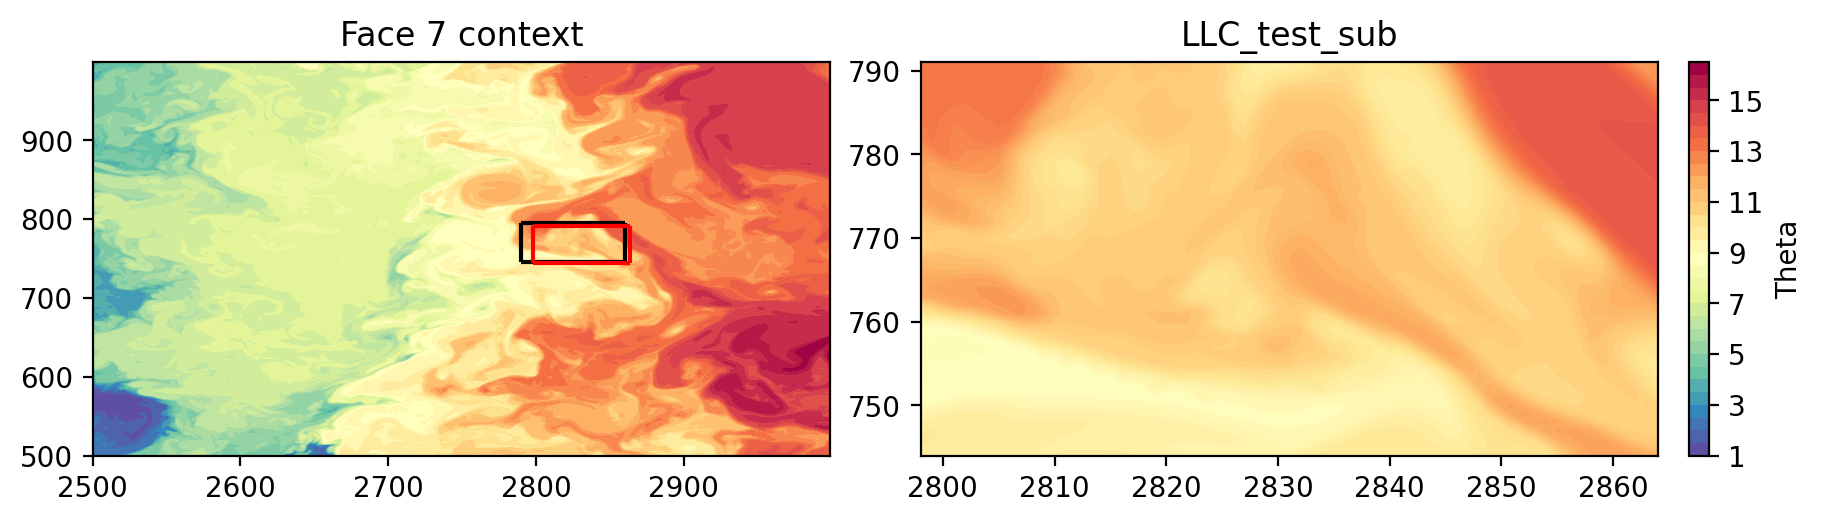

In [ ]:
# visualize Kuroshio sampling location in face 7 
# select face 7, depth = 40m
# i_0 = 2615 # 5 deg
# i_1 = 2965
# j_0 = 620
# j_1 = 870
i_0 = 2790 #1 deg
i_1 = 2860
j_0 = 745
j_1 = 795

LLC_7 = LLC_full.isel(
    face=7,
    k=14,
    i=slice(0, 4320),
    j=slice(0, 4320),
    time=2800
)

Theta_sub = LLC_test_sub.isel(k=14, time=2800)['Theta']

# shared color limits
vmin = min(
    np.min(LLC_7['Theta']).values,
    np.min(Theta_sub).values
)
vmax = max(
    np.max(LLC_7['Theta']).values,
    np.max(Theta_sub).values
)

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 2.5),
    dpi=200,
    constrained_layout=True
)

# -------------------------
# Panel 1: Face 7 context
# -------------------------
ax = axs[0]
cf1 = ax.contourf(
    LLC_7['Theta']['i'],
    LLC_7['Theta']['j'],
    LLC_7['Theta'],
    cmap="Spectral_r",
    vmin=vmin,
    vmax=vmax,
    levels=30
)

# # black box around sampling box
# ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='k')
# ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='k')
# ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='k')
# ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='k')

ax.hlines(y=j00, xmin=i00, xmax=i01, colors='r')
ax.hlines(y=j01, xmin=i00, xmax=i01, colors='r')
ax.vlines(x=i00, ymin=j00, ymax=j01, colors='r')
ax.vlines(x=i01, ymin=j00, ymax=j01, colors='r')

#rotate_axes_90_clockwise(ax)
ax.set_title("Face 7 context")

# -------------------------
# Panel 2: Extracted subset
# -------------------------
ax = axs[1]
cf2 = ax.contourf(
    Theta_sub['i'],
    Theta_sub['j'],
    Theta_sub,
    cmap="Spectral_r",
    vmin=vmin,
    vmax=vmax,
    levels=30
)

#rotate_axes_90_clockwise(ax)
ax.set_title("LLC_test_sub")

# -------------------------
# Shared colorbar
# -------------------------
cbar = fig.colorbar(
    cf1,
    ax=axs,
    orientation="vertical",
    fraction=0.035,
    pad=0.02
)
cbar.set_label("Theta")

plt.show()

39°N, 66°W

In [13]:
boxes = llc_latlon_box_indices(
    LLC_full,
    lat_center=39.0,
    lon_center=-66.0,
    degree_extent=1.0
)

for face, (j0, j1, i0, i1) in boxes.items():
    LLC_gulf_stream = LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))

In [15]:
j00 = LLC_gulf_stream.j.values.min()
j01 = LLC_gulf_stream.j.values.max()

i00 = LLC_gulf_stream.i.values.min()
i01 = LLC_gulf_stream.i.values.max()

In [ ]:
LLC_7 = LLC_full.isel(
    face=10,
    k=14,
    i=slice(0, 4320),
    j=slice(0, 4320),
    time=2800
)

Theta_sub = LLC_test_sub.isel(k=14, time=2800)['Theta']

# shared color limits
vmin = min(
    np.min(LLC_7['Theta']).values,
    np.min(Theta_sub).values
)
vmax = max(
    np.max(LLC_7['Theta']).values,
    np.max(Theta_sub).values
)

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 2.5),
    dpi=200,
    constrained_layout=True
)

# -------------------------
# Panel 1: Face 7 context
# -------------------------
ax = axs[0]
cf1 = ax.contourf(
    LLC_7['Theta']['i'],
    LLC_7['Theta']['j'],
    LLC_7['Theta'],
    cmap="Spectral_r",
    vmin=vmin,
    vmax=vmax,
    levels=30
)

# red box around sampling box

ax.hlines(y=j00, xmin=i00, xmax=i01, colors='r')
ax.hlines(y=j01, xmin=i00, xmax=i01, colors='r')
ax.vlines(x=i00, ymin=j00, ymax=j01, colors='r')
ax.vlines(x=i01, ymin=j00, ymax=j01, colors='r')

#rotate_axes_90_clockwise(ax)
ax.set_title("Face 7 context")

# -------------------------
# Panel 2: Extracted subset
# -------------------------
ax = axs[1]
cf2 = ax.contourf(
    Theta_sub['i'],
    Theta_sub['j'],
    Theta_sub,
    cmap="Spectral_r",
    vmin=vmin,
    vmax=vmax,
    levels=30
)

#rotate_axes_90_clockwise(ax)
ax.set_title("LLC_test_sub")

# -------------------------
# Shared colorbar
# -------------------------
cbar = fig.colorbar(
    cf1,
    ax=axs,
    orientation="vertical",
    fraction=0.035,
    pad=0.02
)
cbar.set_label("Theta")

plt.show()

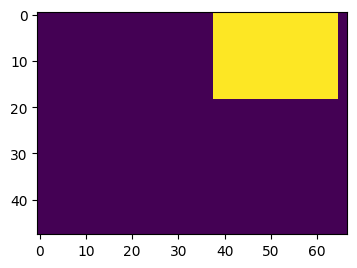

In [ ]:
# build tile index
tile_width= 0.4
tile_index = build_sub_index(LLC_test_sub, tile_width,"tile").compute()
LLC_test_sub_ = LLC_test_sub.assign_coords(tile=tile_index)
# mask invalid pixels (the purple edges in the fig below)
LLC_test_sub_ = LLC_test_sub_.where(LLC_test_sub_.tile >= 0)
plt.figure(figsize=(4,6))
plt.imshow(tile_index)

1  Define W (vertical velocity) and T (Theta, potential temperature) within a 1 deg x 1 deg box centered at 39N, 158E in the LLC4320 dataset. Split into 4 0.5 deg x 0.5 deg sub-boxes.

In [7]:
# subset to 1 or 5 deg x 1 or 5 deg box centered at 159, 39
# set i,j extents of the spatial box
# # these are approx 5x5 deg:
# i_0 = 2615
# i_1 = 2965
# j_0 = 620
# j_1 = 870
# these are 1x1 deg:
 i_0 = 2790
 i_1 = 2860
 j_0 = 745
 j_1 = 795
LLC_sub = LLC_full.isel(i = slice(i_0, i_1), j = slice(j_0, j_1), face = 7,k=14)


# calculate a .5 deg lat by .5 deg lon box in i,j:
XC = LLC_sub['XC'].values
YC = LLC_sub['YC'].values
lon_extent = (np.max(XC)) - (np.min(XC))
lat_extent = (np.max(YC)) - (np.min(YC))

box_dim = 0.1
num_lon_box = lon_extent/box_dim
num_lat_box = lat_extent/box_dim

IndentationError: unexpected indent (834587317.py, line 9)

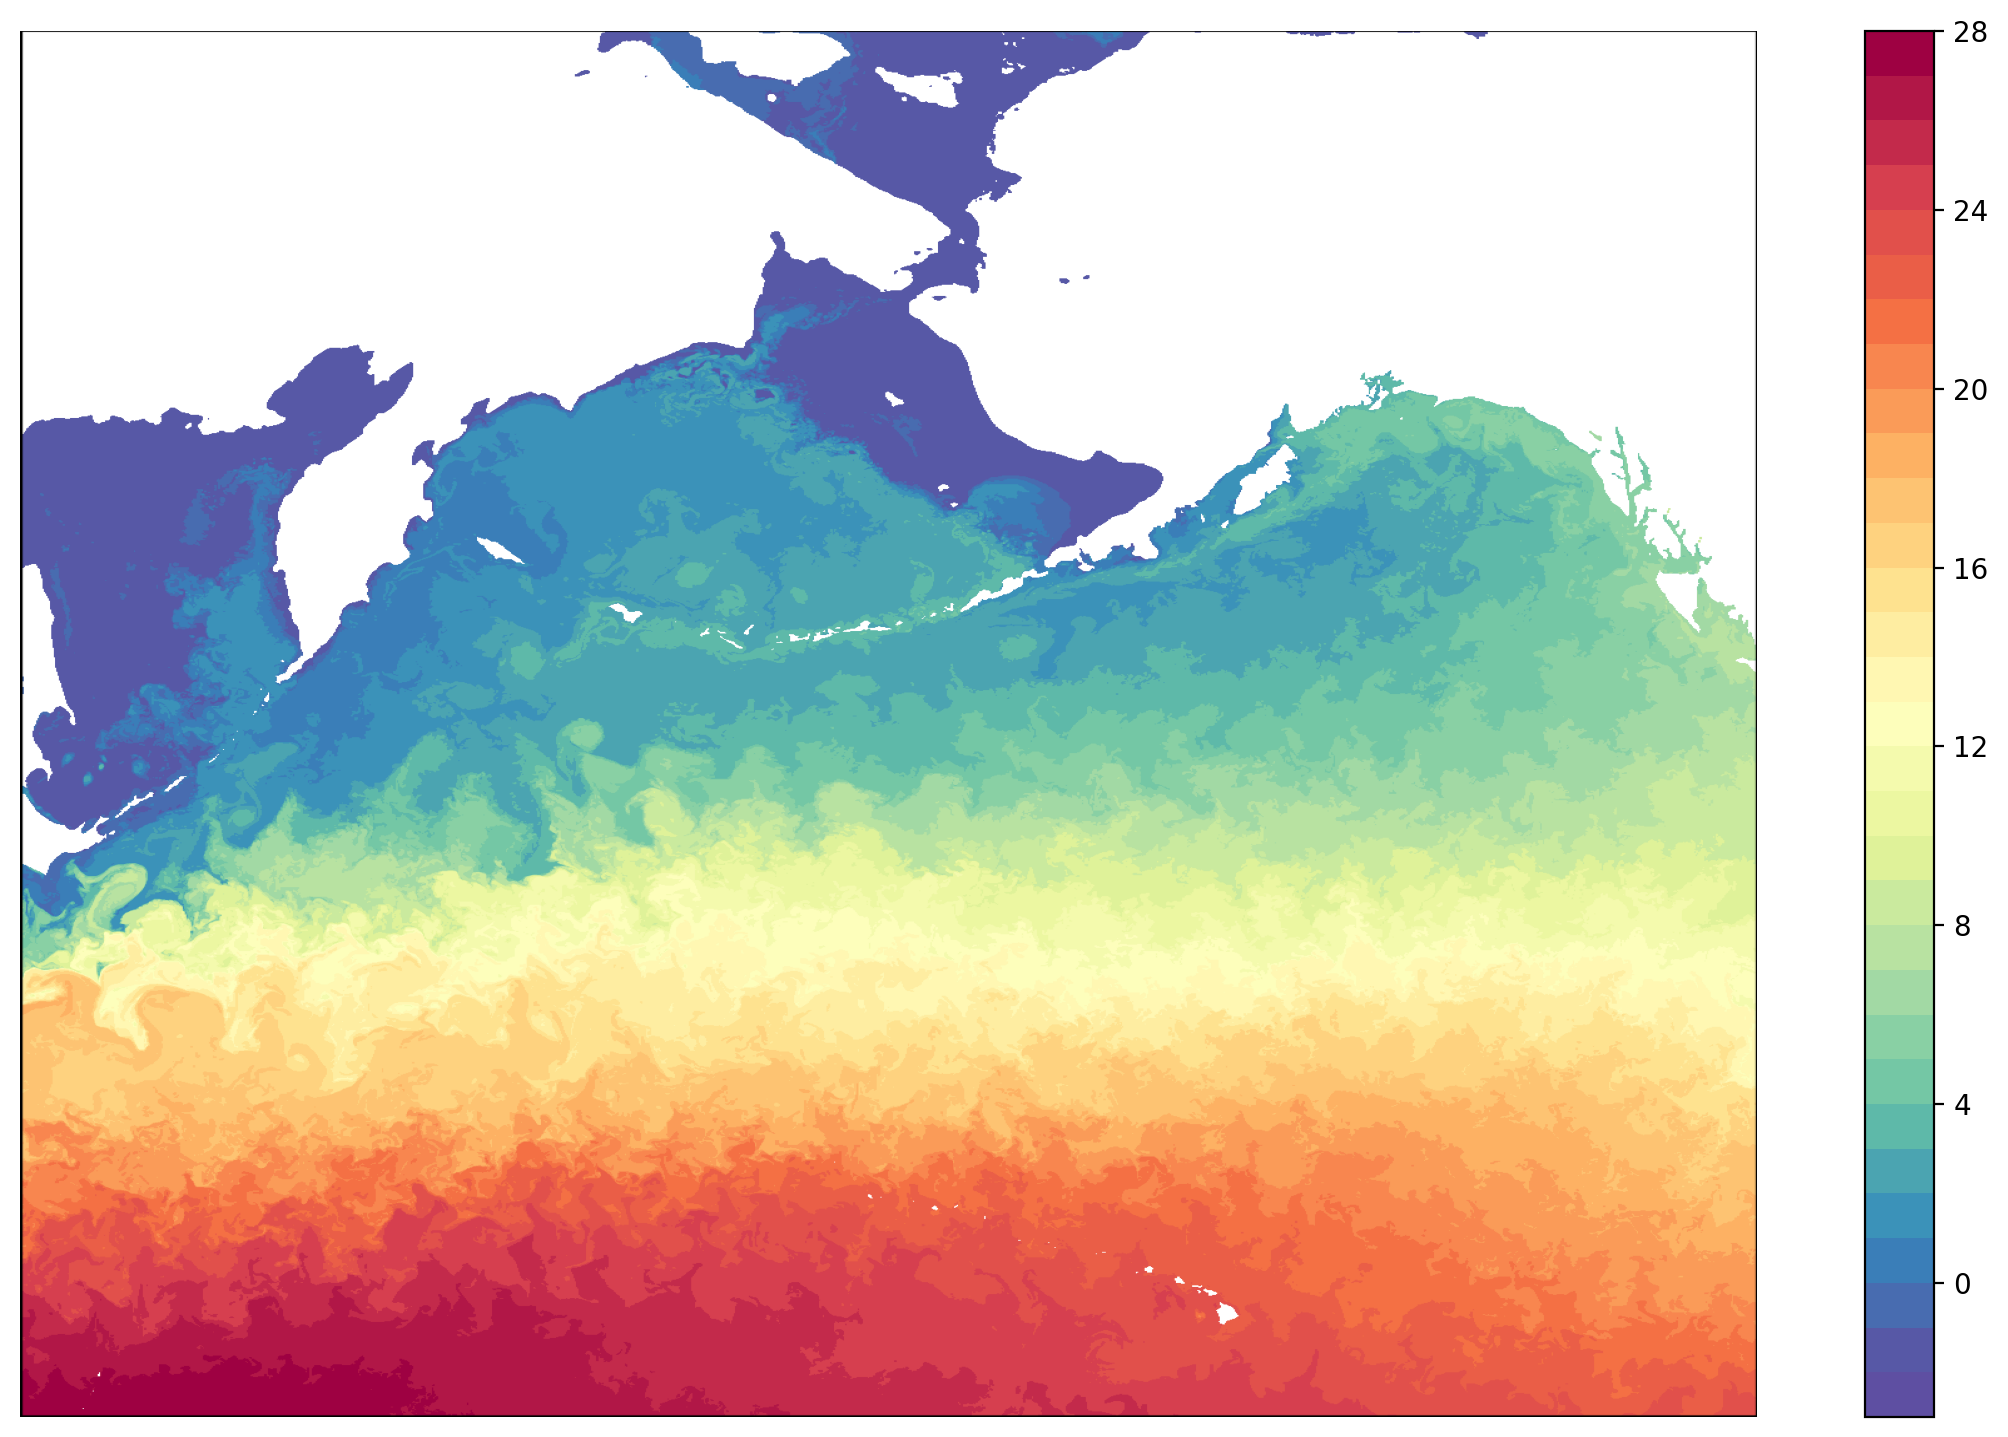

In [7]:
# visualize Kuroshio sampling location in face 7 
# select face 7, depth = 40m
LLC_7 = LLC_full.isel(face = 7, k = 14)#, i = slice(3000,3100), j= slice(1000,1100))
fig, ax = plt.subplots(figsize=(14,9),dpi=200)
cf = ax.contourf(LLC_7.isel(time = 4600)['Theta']['i'], LLC_7.isel(time = 4600)['Theta']['j'], LLC_7.isel(time = 4600)['Theta'], cmap="Spectral_r",vmin=np.min(LLC_7.isel(time = 4600)['Theta']).values,vmax=np.max(LLC_7.isel(time = 4600)['Theta']).values, levels = 30)
# black box around sampling box
# ax.hlines(y=745, xmin=2790, xmax=2860, colors='k')
# ax.hlines(y=795, xmin=2790, xmax=2860, colors='k')
# ax.vlines(x=2790, ymin=745, ymax=795, colors='k')
# ax.vlines(x=2860, ymin=745, ymax=795, colors='k')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

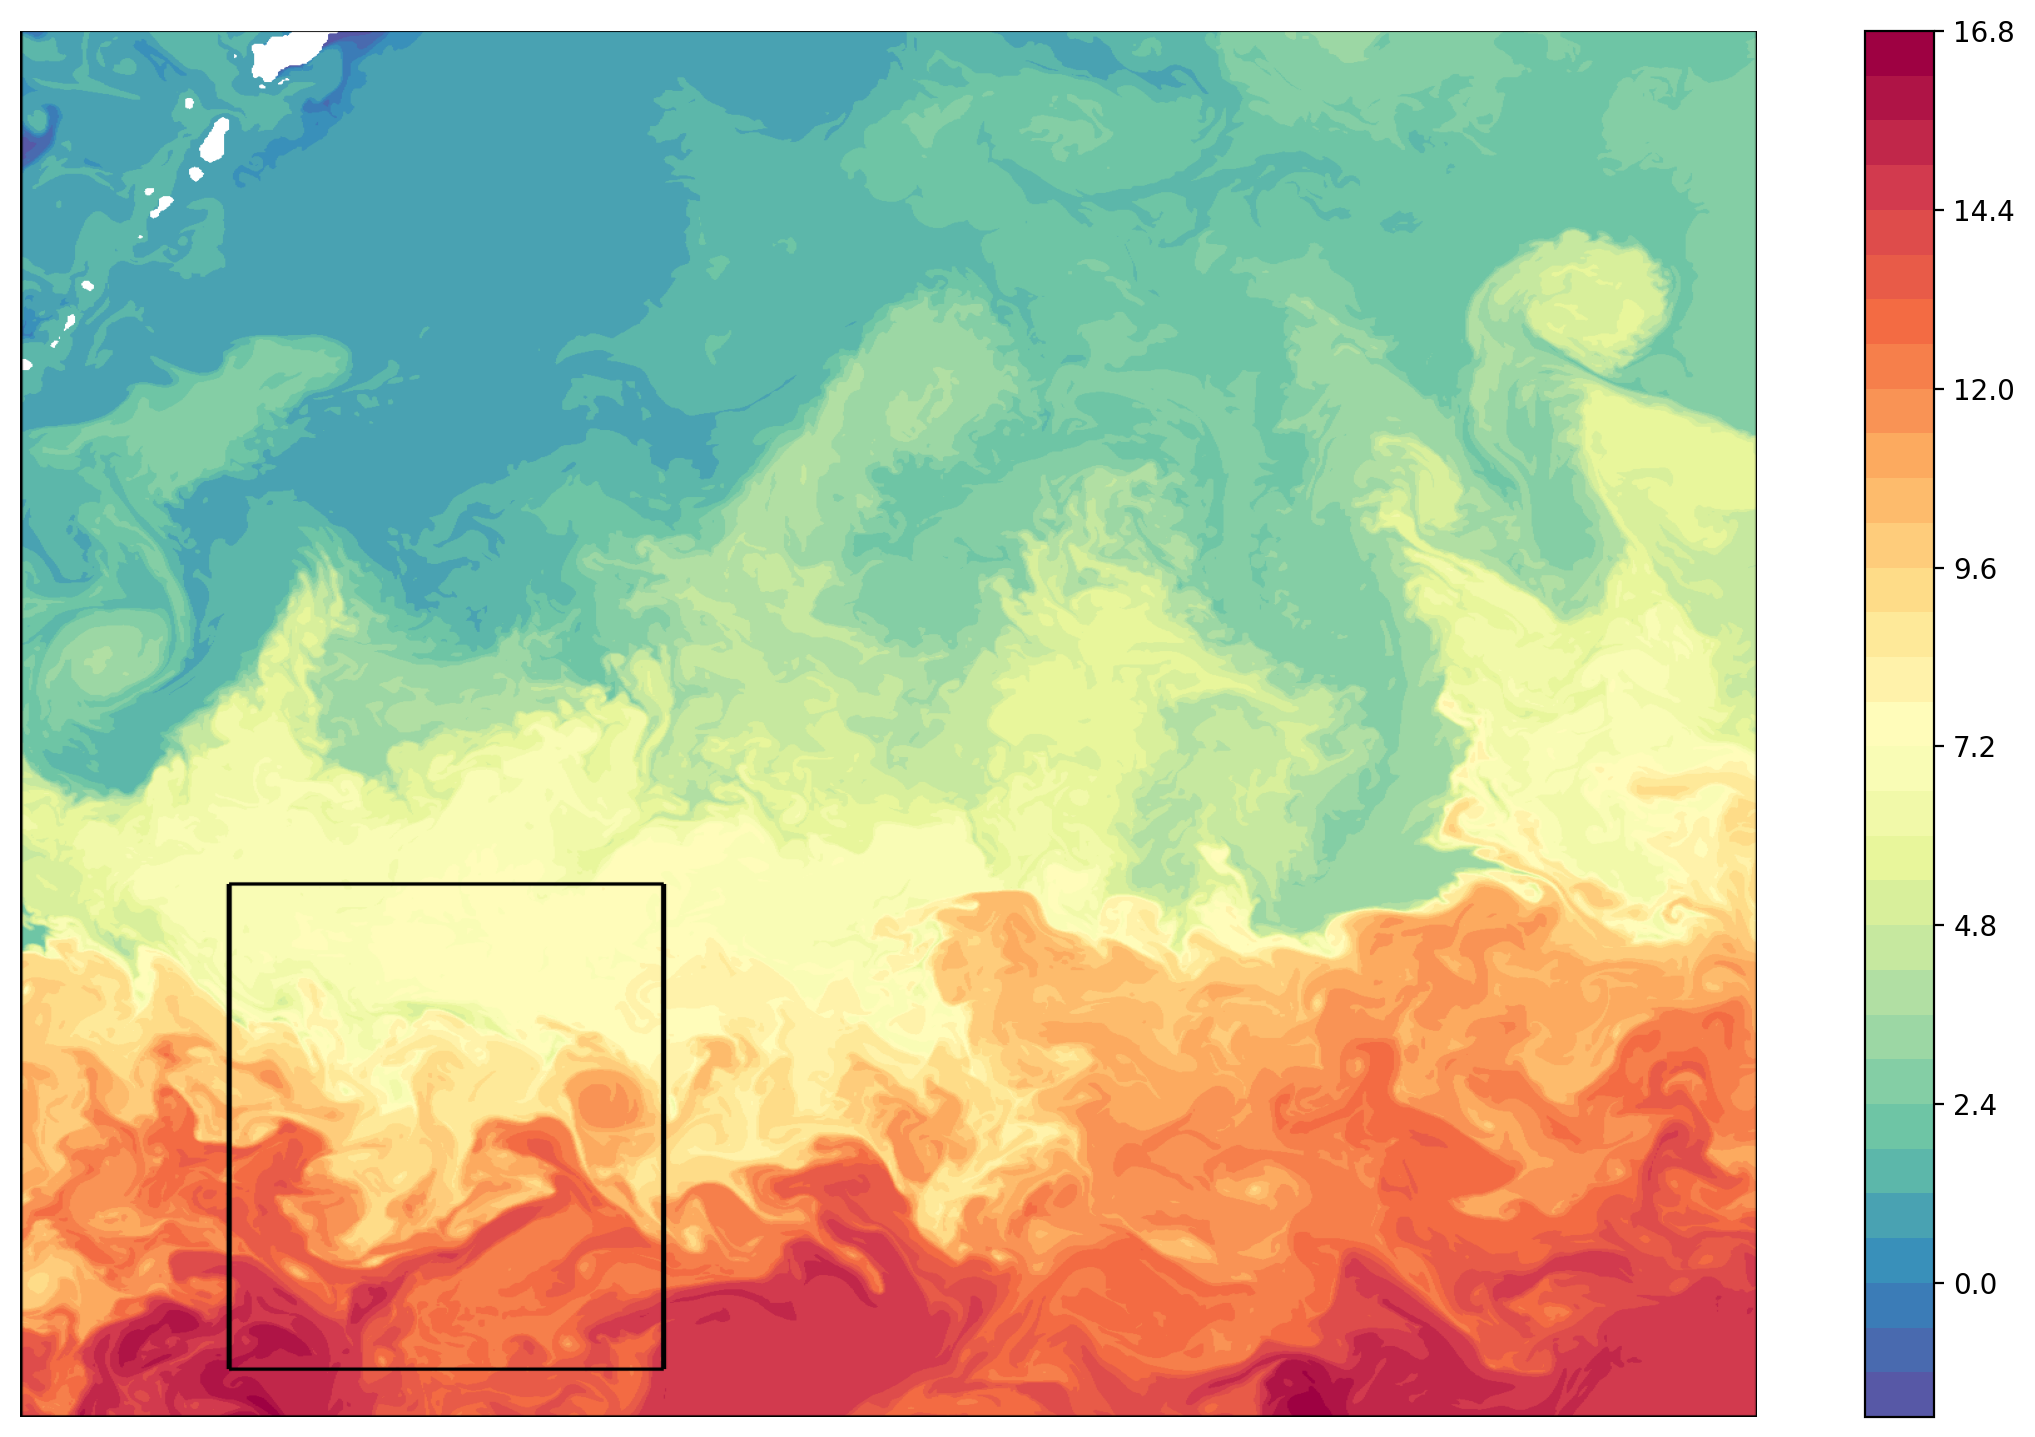

In [8]:
# visualize Kuroshio sampling location in face 7 
# select face 7, depth = 40m
LLC_7 = LLC_full.isel(face = 7, k = 14, i = slice(2000,3000), j= slice(500,1500))
fig, ax = plt.subplots(figsize=(14,9),dpi=200)
cf = ax.contourf(LLC_7.isel(time = 4600)['Theta']['i'], LLC_7.isel(time = 4600)['Theta']['j'], LLC_7.isel(time = 4600)['Theta'], cmap="Spectral_r",vmin=np.min(LLC_7.isel(time = 4600)['Theta']).values,vmax=np.max(LLC_7.isel(time = 4600)['Theta']).values, levels = 30)
# black box around sampling box
ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='k')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='k')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='k')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='k')

plt.colorbar(cf, ax = ax)
#ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)
plt.show()

In [ ]:
lon_min = np.nanmin(XC)
lat_min = np.nanmin(YC)



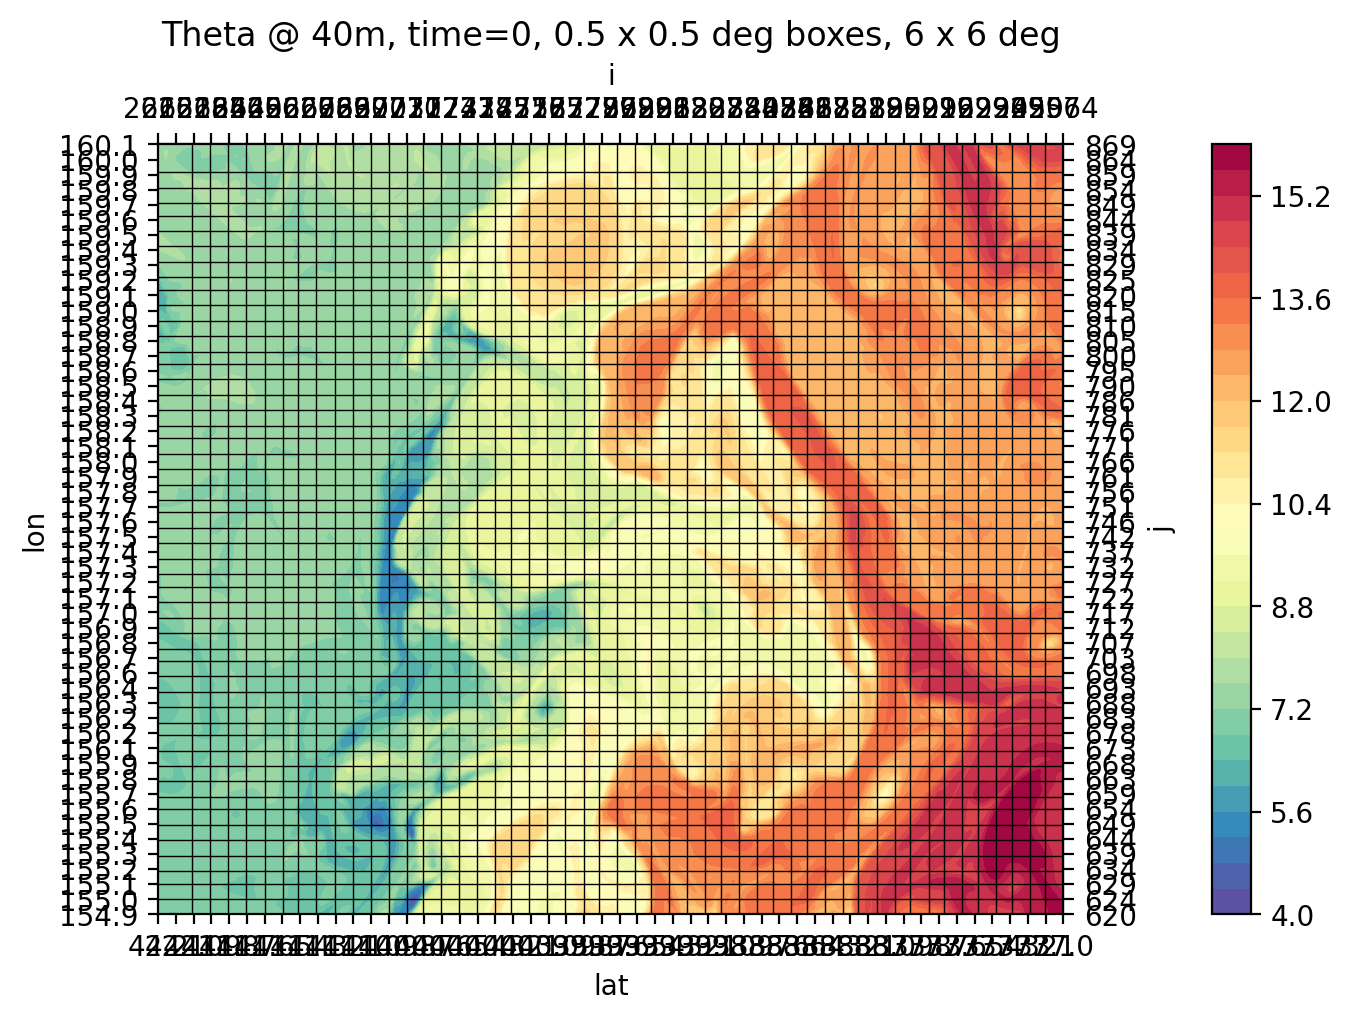

In [11]:
# visualize the subset and the .5x.5 boxes
fig, ax = plt.subplots(figsize=(8,5),dpi=200)

cf = ax.contourf(LLC_sub.isel(time = 4600)['Theta']['i'], LLC_sub.isel(time = 4600)['Theta']['j'], LLC_sub.isel(time = 4600)['Theta'], cmap="Spectral_r",
    vmin=np.min(LLC_sub.isel(time = 4600)['Theta']).values,vmax=np.max( LLC_sub.isel(time = 4600)['Theta']).values, levels = 30)

i_inds = [int(vals)for vals in ([LLC_sub.isel(time = 4600)['XC'][index, :]['j'].values for index in i_j_from_lat_lon(XC, num_lon_box, lon_min)[0]])]
j_inds = [int(vals)for vals in ([LLC_sub.isel(time = 4600)['YC'][:, index]['i'].values for index in i_j_from_lat_lon(YC, num_lat_box, lat_min)[1]])]

for box in range(int(num_lon_box)):
    plt.axvline(j_inds[box], c = 'k',linewidth = 0.5)
    plt.axhline(i_inds[box], c = 'k',linewidth = 0.5)

lats, lons = lat_lon_from_i_j(LLC_sub.isel(time = 4600))

ax.set_xticks(np.linspace(int(np.min(LLC_sub.isel(time = 4600)['i'].values)), int(np.max(LLC_sub.isel(time = 4600)['i'].values)), int(num_lon_box)+1))
ax.set_yticks(np.linspace(int(np.min(LLC_sub.isel(time = 4600)['j'].values)), int(np.max(LLC_sub.isel(time = 4600)['j'].values)), int(num_lon_box)+1))

yticks = ax.get_yticks() # i
xticks = ax.get_xticks() # j

ax.set_xticklabels([round(lats[0][idx],1) for idx in [int(round(i)) for i in np.linspace(0, len(lats[0]) -1, len(xticks))]])
ax.set_yticklabels([round(lons[0][idx],1) for idx in [int(round(i)) for i in np.linspace(0, len(lons[0]) -1, len(yticks))]])

# secondary axis
secax_x = ax.secondary_xaxis('top')
secax_x.set_xlim(ax.get_xlim())
secax_x.set_xticks(xticks)   # FIXED: use xticks here
secax_x.set_xticklabels([f"{int(t)}" for t in xticks])
secax_x.set_xlabel('i')
secax_x.tick_params(which='both', length=4)

secax_y = ax.secondary_yaxis('right')
secax_y.set_ylim(ax.get_ylim())
secax_y.set_yticks(yticks)   # FIXED: use yticks here
secax_y.set_yticklabels([f"{int(t)}" for t in yticks])
secax_y.set_ylabel('j')
secax_y.tick_params(which='both', length=4)


plt.title('Theta @ 40m, time=0, 0.5 x 0.5 deg boxes, 6 x 6 deg')
plt.colorbar(cf, ax=ax, pad=0.12)

ax.set_xlabel('lat')
ax.set_ylabel('lon')

plt.show()

2. interpolate W using grid_3d.interp along the z axis. This is necessary as Theta values are spatially centered within LLC pixels while W (vertical velocity) values are horizontally centered, but vertically shifted to the edges of LLC pixels.

In [7]:
# redefine LLC_sub without k selection for interpolation
# i_0 = 2790
# i_1 = 2860
# j_0 = 745
# j_1 = 795
i_0 = 2790
i_1 = 2860
j_0 = 745
j_1 = 795

LLC_sub = LLC_full.isel(i = slice(i_0, i_1), j = slice(j_0, j_1), face = 7)

# select temporal subset for testing-----
temporal_chunk = 12
t_0 = 4000
t_1 = t_0 + temporal_chunk * 4
LLC_testing = LLC_sub.isel(time = slice(t_0, t_1)).chunk({'time': -1, 'i': -1, 'j': -1})

# define and interpolate vertical velocity
grid_3d = xgcm.Grid(
    LLC_testing,
    coords={
        'Z': {'center': 'k', 'left': 'k_p1'}},
    autoparse_metadata=False)

LLC_testing['W_interp'] = grid_3d.interp(LLC_testing['W'], 'Z', boundary='extend')

LLC_sub = LLC_testing.isel(k=14)

3. define half-deg sub-boxes, coarse grain the means spatially in each 0.5 x 0.5 box at each hourly time t 

In [ ]:
# function to select i-j slices per box by lat/lon boxes
def i_j_slices(LLC, spacing):
    i_start, i_end = [], []
    j_start, j_end = [], []

    XC, YC= LLC['XC'].values, LLC['YC'].values

  #  i_min, j_min = np.min(LLC['i'].values), np.min(LLC['j'].values)

    extent = (np.nanmax(XC)) - (np.nanmin(XC))
    num_boxes = extent/spacing 

    lon_min, lat_min= np.nanmin(XC), np.nanmin(YC)

    for box in range(int(num_boxes)):
        # start lat/lon
        lon_start, lat_start = lon_min + spacing * box, lat_min + spacing * box

        # end lat/lon
        lon_end, lat_end = lon_min + spacing * box + spacing, lat_min + spacing * box + spacing

        # convert to i,j
        lon_dist_s, lat_dist_s = np.nanargmin(np.abs(XC - lon_start)),  np.nanargmin(np.abs(YC - lat_start))
        (_,i_s), (j_s,_) = np.unravel_index(lat_dist_s, YC.shape), np.unravel_index(lon_dist_s, XC.shape)

        lon_dist_e, lat_dist_e = np.nanargmin(np.abs(XC - lon_end)),  np.nanargmin(np.abs(YC - lat_end))
        (_,i_e), (j_e,_) = np.unravel_index(lat_dist_e, YC.shape), np.unravel_index(lon_dist_e, XC.shape)


        i_start.append(int(i_e)), i_end.append(int(i_s)), j_start.append(int(j_s)), j_end.append(int(j_e))
   # print (f'i: {i_start[::-1]}, {i_end[::-1]}, j: {j_start}, {j_end}, {int(num_boxes)}')
    return i_start[::-1], i_end[::-1], j_start, j_end, int(num_boxes)


def iterate_boxes(LLC, resolution_deg=0.1):

    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, resolution_deg)

    box_id = 0
    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):
            # only yield boxes with valid size
            if (i1 - i0) > 0 and (j1 - j0) > 0:
                yield box_id, (i0, i1, j0, j1)
                box_id += 1
                
# function to build a box index
def build_box_index(LLC, resolution_deg):
    box = xr.full_like(LLC["XC"], fill_value=-1).astype(int)
    box = box.rename(["box"])

    for box_id, (i0, i1, j0, j1) in iterate_boxes(LLC, resolution_deg):
        box[j0:j1, i0:i1] = box_id
    return box

# build box index
box_index = build_box_index(LLC_sub,resolution_deg=0.5).load()
LLC_sub = LLC_sub.assign_coords(box=box_index)
plt.figure(figsize=(4,6))
plt.imshow(box_index)

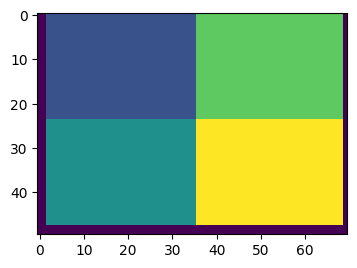

In [ ]:
W = LLC_sub['W_interp']
T = LLC_sub['Theta']

"""
5. coarse grain spatially and break into tiles for fft
"""

# define WT_m, W_m, T_m, weighting by surface cell areas
A = LLC_sub['rA']
WT_m = ((W * T * A).groupby("box").sum() / A.groupby("box").sum())
valid = WT_m.box != -1
WT_m = WT_m.where(valid)
W_m = ((W * A).groupby("box").sum() / A.groupby("box").sum()).where(valid)
T_m = ((T * A).groupby("box").sum() / A.groupby("box").sum()).where(valid)


"""
6. calculate the total VHF with $C_p \rho <W'T'>$ for each time t, where <W'T'> = bar(WT) - bar(W) bar(T)
"""

# calculate <W'T'>, avg by box
C_p, rho = 3900, 1025
total_WT_ = (WT_m.mean(dim="box") - (W_m.mean(dim="box") * T_m.mean(dim="box")))

VHF_total = C_p * rho * total_WT_

In [ ]:
"""
7. take the temporal fourier transform of W and T fields using fft
"""

In [ ]:
"""
7. take the temporal fourier transform of W and T fields using xrft
"""
# weight i,j pixels by their surface area
A_norm = A / A.groupby("box").sum()
W_aw = W * A_norm
T_aw = T * A_norm
# mask invalid box
valid = (W_aw.box != -1)
W_aw = W_aw.where(valid)
T_aw = T_aw.where(valid)


In [11]:
# convert datetime64[ns] to hours since first time step for xrft freq calculation
W_aw = W_aw.assign_coords(
    time=((W_aw.time - W_aw.time[0]) / np.timedelta64(1, 'h')))
T_aw= T_aw.assign_coords(
    time=((T_aw.time - T_aw.time[0]) / np.timedelta64(1, 'h')))

In [12]:
# fluctuations from the mean
W_prime = (W_aw - W_aw.mean(dim="time"))
T_prime = (T_aw - T_aw.mean(dim="time"))

In [13]:
# # FLUCTUATIONS:
# exp_name = "FFT_FLUCTUATIONS"
# # decompose into fluctuations of the fields

# W_f = xrft.fft(W_prime, dim = 'time', true_phase=True, true_amplitude=True)
# T_f = xrft.fft(T_prime, dim = 'time', true_phase=True, true_amplitude=True)

W_f = xrft.fft(W_prime, dim = 'time', true_phase=True, true_amplitude=True)
T_f = xrft.fft(T_prime, dim = 'time', true_phase=True, true_amplitude=True)

In [14]:
"""
8. define LF and HF by respectively applying a low and high pass filter to W and T using a mask and inverse fourier transform back into time space
"""
dt = 1.0
LF_cutoff = 24 
fc = dt / LF_cutoff
freq = W_f.freq_time

LF_mask = (abs(freq) <= fc)
HF_mask = (abs(freq) > fc)

W_LF_f = W_f * LF_mask
W_HF_f = W_f * HF_mask

T_LF_f = T_f * LF_mask
T_HF_f = T_f * HF_mask

# W_LF_f = W_f.where(abs(freq) > fc, drop=False)
# T_LF_f = T_f.where(abs(freq) > fc, drop=False)
# W_HF_f = W_f.where(abs(freq) <= fc, drop=False)
# T_HF_f = T_f.where(abs(freq) <= fc, drop=False)

# W_LF2_f = W_f.where(abs(freq2) < fc, drop=False)
# T_LF2_f = T_f.where(abs(freq2) < fc, drop=False)
# W_HF2_f = W_f.where(abs(freq2) >= fc, drop=False)
# T_HF2_f = T_f.where(abs(freq2) >= fc, drop=False)

In [15]:
# inverse fourier transform back into time space, take the real
W_LF = xrft.ifft(W_LF_f, dim = 'freq_time', true_phase=True, true_amplitude=True).real
W_HF = xrft.ifft(W_HF_f, dim = 'freq_time', true_phase=True, true_amplitude=True).real
T_LF = xrft.ifft(T_LF_f, dim = 'freq_time', true_phase=True, true_amplitude=True).real
T_HF = xrft.ifft(T_HF_f, dim = 'freq_time', true_phase=True, true_amplitude=True).real

/home/codycruz/.venv/lib64/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/codycruz/.venv/lib64/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/codycruz/.venv/lib64/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/codycruz/.venv/lib64/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=Non

In [16]:
# plt.plot(W_LF.isel(box=2), label = 'LF')
# plt.plot(W_HF.isel(box=2), label = 'HF')
# plt.plot(W_tiles.isel(box=2), label = 'W_tiles')
# plt.title('W')
# plt.legend(loc = 'lower right')
# plt.show()

# plt.plot(T_LF.isel(box=2), label = 'LF')
# plt.plot(T_HF.isel(box=2), label = 'HF')
# plt.plot(T_tiles.isel(box=2), label = 'T_tiles')
# plt.legend(loc = 'lower right')
# plt.title('T')
# plt.show()

  """
    9. define LF and HF VHF respectively with $C_p \rho W_{lowpass} T_{lowpass}$ and $C_p \rho W_{highpass} T_{highpass}$
    """

In [17]:
# LF
WT_LF = (W_LF * T_LF).groupby("box").sum(dim=('j','i'))
Wm_LF = W_LF.groupby("box").sum(dim=('j','i'))
Tm_LF = T_LF.groupby("box").sum(dim=('j','i'))

# HF
WT_HF = (W_HF * T_HF).groupby("box").sum(dim=('j','i'))
Wm_HF = W_HF.groupby("box").sum(dim=('j','i'))
Tm_HF = T_HF.groupby("box").sum(dim=('j','i'))


# Box-mean VHF
C_p, rho = 3900, 1025

LF_VHF = C_p * rho * (WT_LF.mean("box") - Wm_LF.mean("box") * Tm_LF.mean("box"))

HF_VHF = C_p * rho * (WT_HF.mean("box") - Wm_HF.mean("box") * Tm_HF.mean("box"))

VHF_total_sum = LF_VHF + HF_VHF

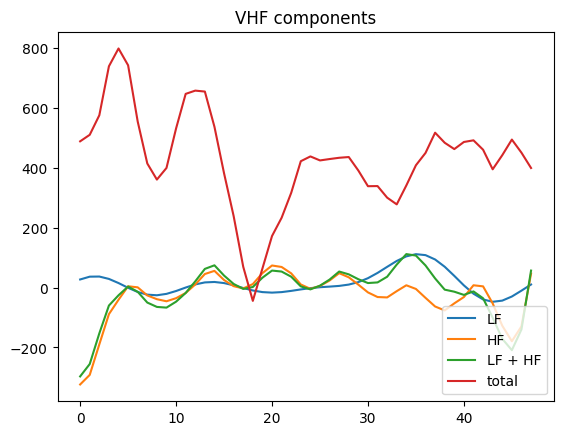

In [ ]:
plt.plot(LF_VHF, label = 'LF')
plt.plot(HF_VHF, label = 'HF')
plt.plot(VHF_total_sum, label = 'LF + HF')
plt.plot(VHF_total, label='total')
plt.title('VHF components')
plt.legend(loc = 'lower right')
plt.show()

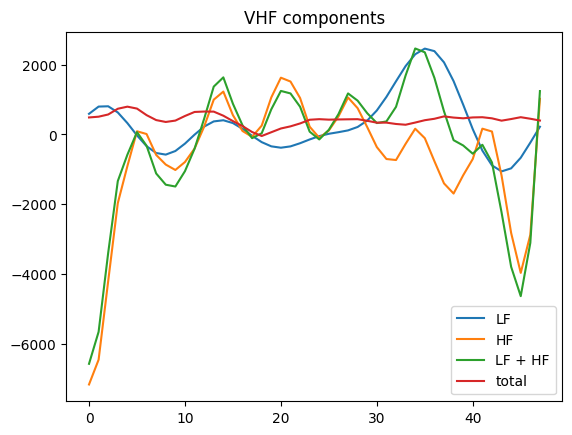

In [18]:
plt.plot(LF_VHF, label = 'LF')
plt.plot(HF_VHF, label = 'HF')
plt.plot(VHF_total_sum, label = 'LF + HF')
plt.plot(VHF_total, label='total')
plt.title('VHF components')
plt.legend(loc = 'lower right')
plt.show()

/home/codycruz/.venv/lib64/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codycruz/.venv/lib64/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


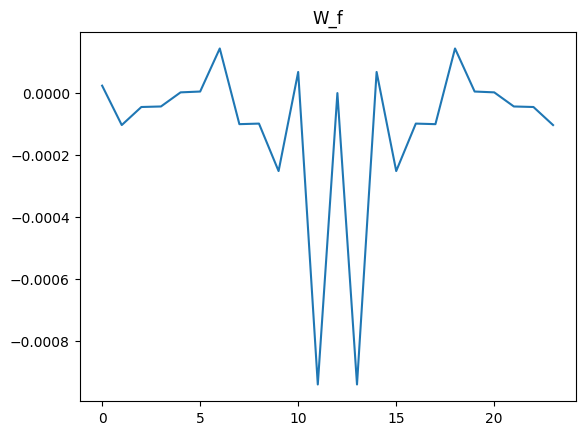

Text(0.5, 1.0, 'T_f')

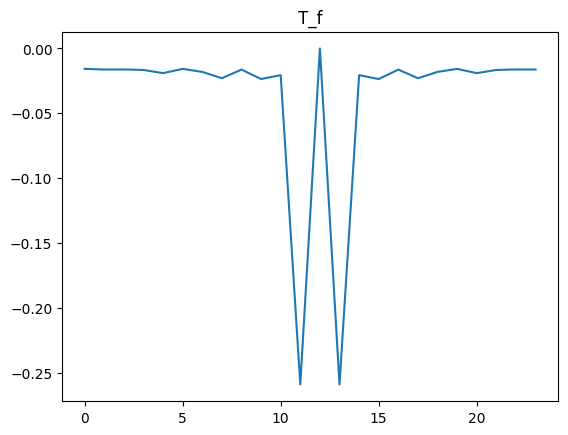

In [36]:
plt.plot(W_f.isel(box=2))
plt.title('W_f')
plt.show()
plt.plot(T_f.isel(box=2))
plt.title('T_f')

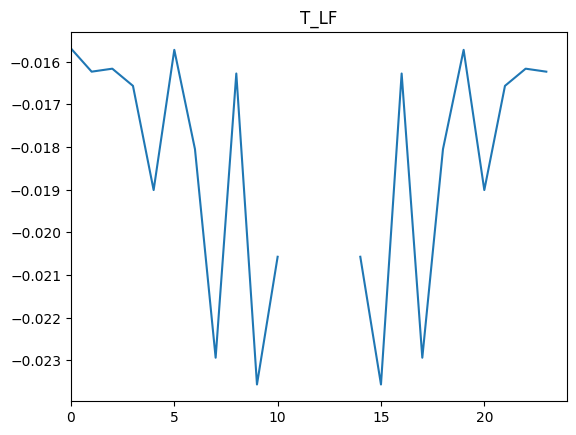

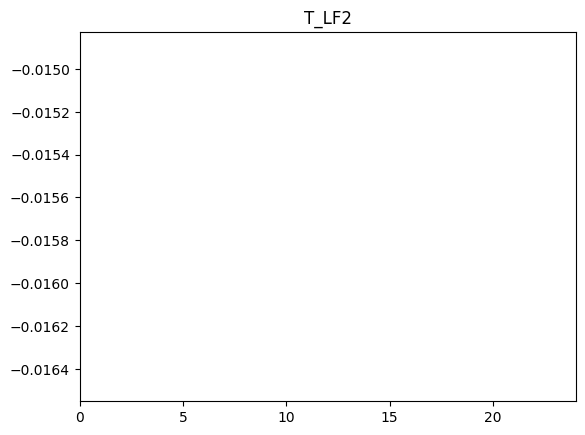

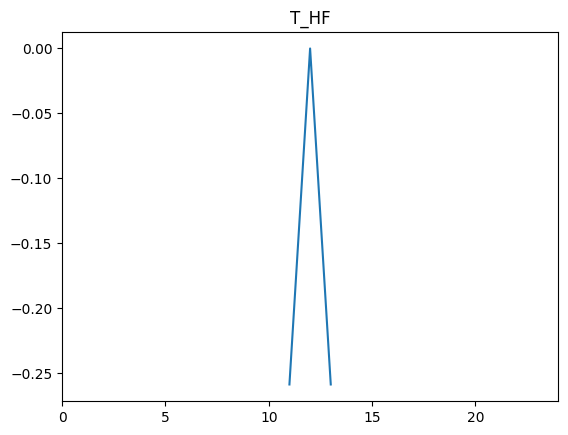

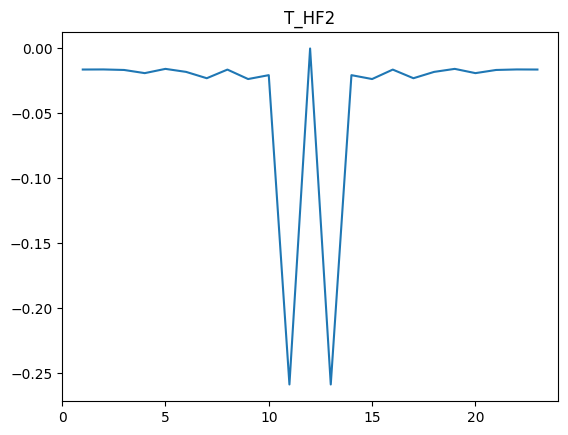

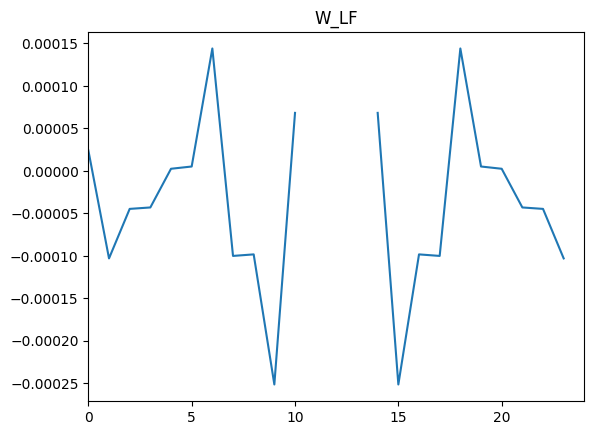

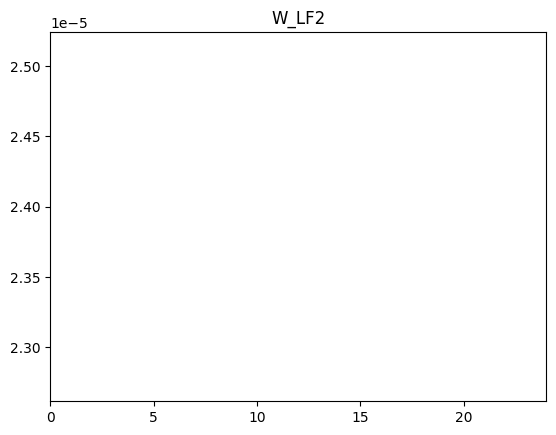

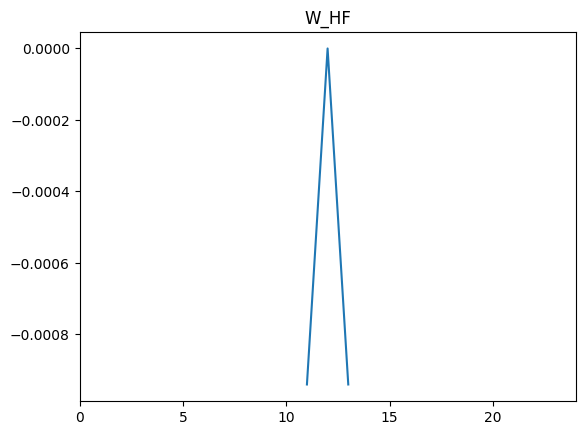

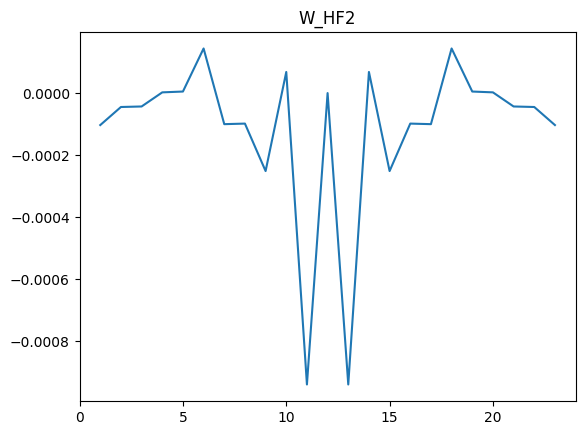

In [ ]:
b = 2
t = 24
plt.plot(T_LF_f.isel(box=b))
plt.title('T_LF')
plt.xlim(0,t)
plt.show()
plt.plot(T_LF2_f.isel(box=b))
plt.title('T_LF2')
plt.xlim(0,t)
plt.show()
plt.plot(T_HF_f.isel(box=b))
plt.title('T_HF')
plt.xlim(0,t)
plt.show()
plt.plot(T_HF2_f.isel(box=b))
plt.title('T_HF2')
plt.xlim(0,t)
plt.show()

plt.plot(W_LF_f.isel(box=b))
plt.title('W_LF')
plt.xlim(0,t)
plt.show()
plt.plot(W_LF2_f.isel(box=b))
plt.title('W_LF2')
plt.xlim(0,t)
plt.show()
plt.plot(W_HF_f.isel(box=b))
plt.title('W_HF')
plt.xlim(0,t)
plt.show()
plt.plot(W_HF2_f.isel(box=b))
plt.title('W_HF2')
plt.xlim(0,t)
plt.show()

In [148]:
W_HF.isel(box=10).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
plt.plot(T_LF.isel(box=1))
plt.show()
plt.plot(T_HF.isel(box=1))

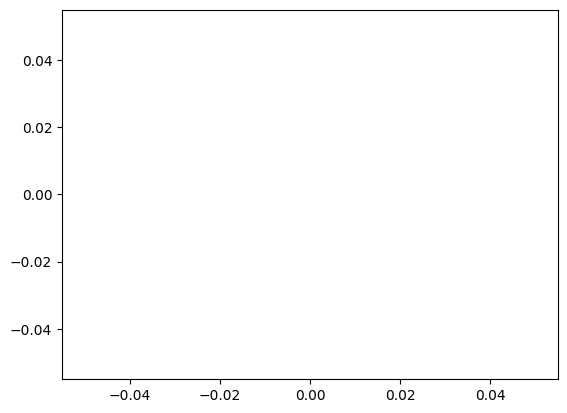

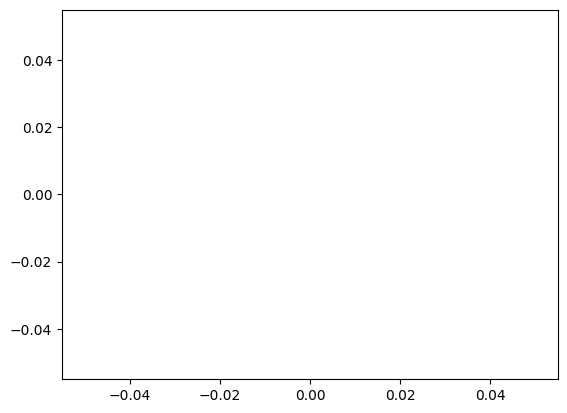

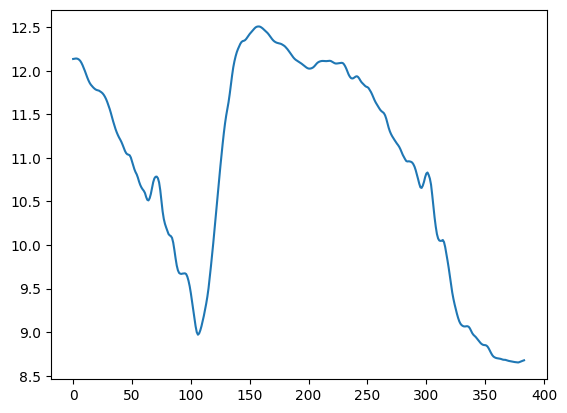

In [148]:
plt.plot(T_tiles.isel(box=1))

In [12]:
# set size of box in degrees lat/lon
box_width = 0.1

# set depth
depth_ind = 14 #40m

# set i,j extents of the spatial box
i_0 = 2790
i_1 = 2860
j_0 = 745
j_1 = 795

# temporal extent of the calculation/time series
t_0 = 4000 #0
t_1 = t_0 +  24 * 4 * 4#429 * 24

# LF average: define the number of hours to be averaged
LF_average = 24

# define seawater heat capacity and density
C_p, rho = 3900, 1025
# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face 7, temporal subset, chunk
LLC_sub = LLC_full.isel(time = slice(t_0,t_1), i = slice(i_0, i_1), j = slice(j_0, j_1), face = 7).chunk({'time': LF_average * 4, 'i': i_1 - i_0, 'j': j_1 - j_0})


"""
4. vertical velocity interpolation
"""

# define and interpolate vertical velocity, operate on all k to correctly weight adjacent faces (xgcm needs full vertical grid information)
grid_3d = xgcm.Grid(
    LLC_sub,
    coords={
        'Z': {'center': 'k', 'left': 'k_p1'}},
    metrics={'Z': ['drF']},
    autoparse_metadata=False)

# define vertical velocity
LLC_sub['W_interp'] = grid_3d.interp(LLC_sub['W'], 'Z', boundary='extend')

# select depth
LLC_sub = LLC_sub.isel(k=14)

# subset to only relevant vars
LLC_sub = LLC_sub[['W_interp','Theta','XC','YC','rA']]

# build, assign box index
box_index = build_box_index(LLC_sub, box_width).compute()
LLC_sub = LLC_sub.assign_coords(box=box_index)

W = LLC_sub['W_interp']
T = LLC_sub['Theta']

In [13]:
#W = LLC_sub['W40']
#T = LLC_sub['T40']
# group into boxes
A = LLC_sub['rA']

WT = (W * T * A).groupby("box").sum() / A.groupby("box").sum()
Wm = (W * A).groupby("box").sum() / A.groupby("box").sum()
Tm = (T * A).groupby("box").sum() / A.groupby("box").sum()

4. calculate the total VHF with $C_p \rho <W'T'>$ for each time t, where\
<W'T'> = bar(WT) - bar(W) bar(T)


In [14]:
valid = (WT.box != -1)
WT = WT.where(valid)
Wm = Wm.where(valid)
Tm = Tm.where(valid)

C_p, rho = 3900, 1025

# calculate <W'T'>, avg by box
total_WT_ = (WT.mean(dim="box") - Wm.mean(dim="box") * Tm.mean(dim="box"))

VHF_total = C_p * rho * total_WT_

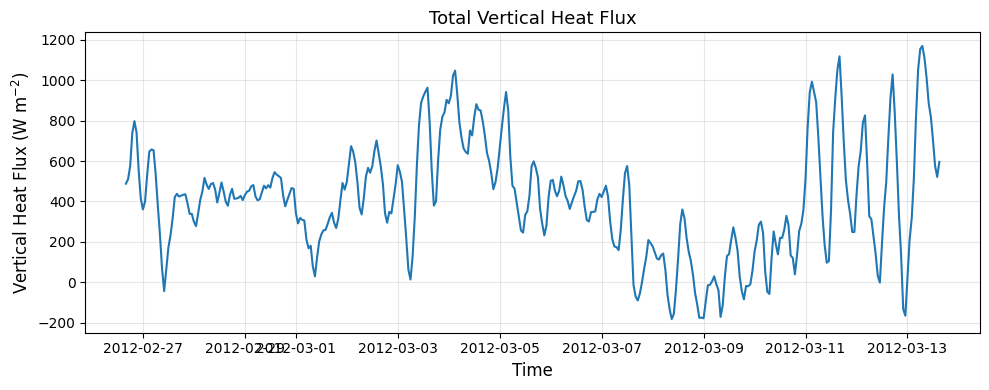

In [14]:
plt.figure(figsize=(10, 4))

plt.plot(
    VHF_total.time,
    VHF_total,
    linewidth=1.5
)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Vertical Heat Flux (W m$^{-2}$)", fontsize=12)
plt.title("Total Vertical Heat Flux", fontsize=13)

plt.grid(True, alpha=0.3)
plt.tight_layout()

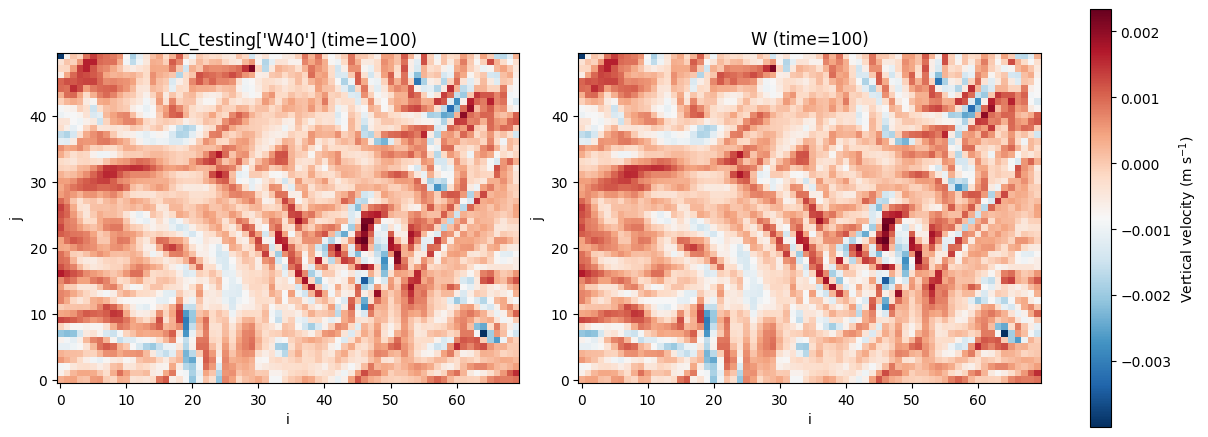

In [18]:
tidx = 100
W_llc = LLC_testing['W40'].isel(time=tidx)
W_new = W.isel(time=tidx)
vmin = np.nanmin([W_llc.min().values, W_new.min().values])
vmax = np.nanmax([W_llc.max().values, W_new.max().values])

fig, axs = plt.subplots(
    ncols=2, figsize=(12, 5), constrained_layout=True
)

# left panel: LLC_testing['W40']
im0 = axs[0].imshow(
    W_llc,
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r"
)
axs[0].set_title("LLC_testing['W40'] (time=100)")
axs[0].set_xlabel("i")
axs[0].set_ylabel("j")

# right panel: W
im1 = axs[1].imshow(
    W_new,
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap="RdBu_r"
)
axs[1].set_title("W (time=100)")
axs[1].set_xlabel("i")
axs[1].set_ylabel("j")

# shared colorbar
cbar = fig.colorbar(im0, ax=axs, shrink=0.85)
cbar.set_label("Vertical velocity (m s$^{-1}$)")

plt.show()

5. break input data into overlapping chunks of length temporal_chunk and window_advancement = 1/4 temporal_chunk, apply Hann windows to reduce spectral leakage -- explore VHF calculated from both $<W'T'>$ and $<W'T'>_{window}$\
for Hann windowed $<W'T'>$, define multiple overlapping temporal windows

In [19]:
# window_advancement = int(1/4 * temporal_chunk)

# # define hanning window temporal length
# hann = np.hanning(temporal_chunk)
# # define hanning window
# hann_da = xr.DataArray(
#     hann,
#     dims=["window_time"])

# # define rolling windows of time
# time_win = (
#     total_WT_.time
#     .rolling(time=temporal_chunk, center=False)
#     .construct("window_time"))

# # define rolling windows
# WT_win = (
#     total_WT_
#     .rolling(time = temporal_chunk, center = False)
#     .construct("window_time"))

# # attach timestamps to WT_win using rolling time windows previously constructed
# WT_win = WT_win.assign_coords(time_window=time_win)

# # select windows
# WT_win = WT_win.isel(time = slice(temporal_chunk - 1, None, window_advancement))

# # construct start and end of centers
# center_start = temporal_chunk // 2 - window_advancement // 2 
# center_end   = temporal_chunk // 2 + window_advancement // 2 

# # extract centers 
# WT_center = WT_win.isel(window_time = slice(center_start, center_end))

# # apply hann window to total
# total_WT_WINDOW = WT_win * hann_da


In [20]:
# # # compute the correction factor = 1/<w^2>
# hann_norm = 1.0 / np.mean(hann**2)

# plt.figure(figsize=(6,3))
# plt.plot(np.linspace(0,len(hann_da),len(hann_da)), hann_da)
# plt.title("Hann Window in Time")
# plt.xlabel("Hours")
# plt.ylabel("Amplitude")
# plt.grid(alpha=0.3)

6. take the temporal fourier transform of the hann window of <W'T'>

In [15]:
# no hann
time_axis = total_WT_.get_axis_num("time")
total_hat = np.fft.fft(total_WT_, axis=time_axis)

# # hann
# time_axis_hann = total_WT_WINDOW.get_axis_num('window_time')
# total_hat_WINDOW = np.fft.fft(total_WT_WINDOW, axis=time_axis)

KeyboardInterrupt: 

7. define LF and HF by respectively applying a low and high pass filter to <W'T'> using a mask and inverse fourier transform back into time space

In [ ]:
# non-hann
dt = 1.0  # data is hourly
Nt = total_WT_.sizes["time"]

freq = np.fft.fftfreq(Nt, d=dt)  # in cycles per hour

# define cutoff
LF_average = 24
fc = dt / LF_average

# define masks
LF_mask = np.abs(freq) <= fc
HF_mask = np.abs(freq) > fc

# reshape masks into [time]
shape = [1] * total_WT_.ndim
shape[time_axis] = Nt

LF_mask_nd = LF_mask.reshape(shape)
HF_mask_nd = HF_mask.reshape(shape)

# apply masks
LF_hat = total_hat * LF_mask_nd
HF_hat = total_hat * HF_mask_nd

In [ ]:
# hann
# dt = 1.0  # data is hourly
# Nt = total_WT_WINDOW.sizes["window_time"]

# freq = np.fft.fftfreq(Nt, d=dt)  # in cycles per hour

# # define cutoff
# LF_average = 24
# fc = dt / LF_average

# # define masks
# LF_mask = np.abs(freq) <= fc
# HF_mask = np.abs(freq) > fc

# # reshape masks into [time, window_time]
# shape = [1] * total_WT_WINDOW.ndim
# shape[time_axis_hann] = Nt

# LF_mask_nd = LF_mask.reshape(shape)
# HF_mask_nd = HF_mask.reshape(shape)

# LF_hat_WINDOW = total_hat_WINDOW * LF_mask_nd
# HF_hat_WINDOW = total_hat_WINDOW * HF_mask_nd

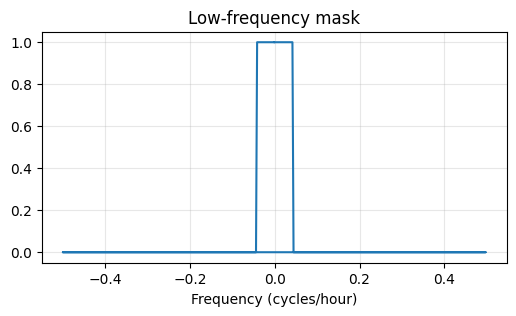

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(freq, LF_mask.astype(int))
plt.xlabel("Frequency (cycles/hour)")
plt.title("Low-frequency mask")
plt.grid(alpha=0.3)

In [ ]:
# inverse fourier transform back into time space, take the real, apply Hann normalization
WT_LF = np.fft.ifft(LF_hat, axis=time_axis).real
WT_HF = np.fft.ifft(HF_hat, axis=time_axis).real 

# WT_LF_WINDOW = np.fft.ifft(LF_hat_WINDOW, axis=time_axis).real * hann_norm
# WT_HF_WINDOW = np.fft.ifft(HF_hat_WINDOW, axis=time_axis).real * hann_norm

In [ ]:
# # convert to dataarrays
# WT_LF_WINDOW = xr.DataArray(
#     WT_LF_WINDOW,
#     dims=("time", "window_time"),
#     coords={
#         "time": WT_win.time,
#         "window_time": WT_win.window_time,
#         "time_window": WT_win.time_window,
#     },
#     name="WT_LF_WINDOW",)
# WT_HF_WINDOW = xr.DataArray(
#     WT_HF_WINDOW,
#     dims=("time", "window_time"),
#     coords={
#         "time": WT_win.time,
#         "window_time": WT_win.window_time,
#         "time_window": WT_win.time_window,
#     },
#     name="WT_HF_WINDOW",)

In [ ]:
# # extract centers
# WT_LF_center = WT_LF_WINDOW.isel(
#     window_time=slice(center_start, center_end))

# WT_HF_center = WT_HF_WINDOW.isel(
#     window_time=slice(center_start, center_end))

In [ ]:
# # stitch into continuous series
# WT_LF_stitched = WT_LF_center.stack(
#     time_continuous=("time", "window_time"))

# WT_HF_stitched = WT_HF_center.stack(
#     time_continuous=("time", "window_time"))

# # assign timestamps
# time_stitched = WT_LF_center.time_window.stack(
#     time_continuous=("time", "window_time"))

# WT_LF_stitched = WT_LF_stitched.reset_index("time_continuous", drop=True)
# WT_HF_stitched = WT_HF_stitched.reset_index("time_continuous", drop=True)

# WT_LF_stitched = WT_LF_stitched.assign_coords(
#     time=("time_continuous", time_stitched.data)
# ).swap_dims({"time_continuous": "time"})

# WT_HF_stitched = WT_HF_stitched.assign_coords(
#     time=("time_continuous", time_stitched.data)
# ).swap_dims({"time_continuous": "time"})

8. define LF and HF VHF respectively with $C_p \rho W_{lowpass} T_{lowpass}$ and $C_p \rho W_{highpass} T_{highpass}$

In [ ]:
# calculate VHF
LF_VHF=  C_p * rho * WT_LF
HF_VHF=  C_p * rho * WT_HF

# LF_VHF_WINDOW =  C_p * rho * WT_LF_stitched
# HF_VHF_WINDOW =  C_p * rho * WT_HF_stitched

# define as xr.dataarray
LF_VHF_1 = xr.DataArray(LF_VHF, coords={"time": VHF_total.time}, dims=["time"], name="LF_VHF")
HF_VHF_1 = xr.DataArray(HF_VHF, coords={"time": VHF_total.time}, dims=["time"], name="HF_VHF")

# LF_VHF_WINDOW =  xr.DataArray(LF_VHF_WINDOW, coords={"time": WT_LF_stitched.time}, dims=["time"], name="LF_VHF")
# HF_VHF_WINDOW =  xr.DataArray(HF_VHF_WINDOW, coords={"time": WT_HF_stitched.time}, dims=["time"], name="HF_VHF")

In [10]:
# OTHER METHOD:
# set size of box in degrees lat/lon
box_width = 0.5

# set depth
depth_ind = 14 #40m

# set i,j extents of the spatial box
i_0 = 2790
i_1 = 2860
j_0 = 745
j_1 = 795

# temporal extent of the calculation/time series
t_0 = 4000 #0
t_1 = t_0 +  24 * 4 * 4#429 * 24

# LF average: define the number of hours to be averaged
LF_cutoff  = 128

# define seawater heat capacity and density
C_p, rho = 3900, 1025

"""
3. open and subset LLC4320
"""

# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face 7, temporal subset, chunk
LLC_sub = LLC_full.isel(time = slice(t_0,t_1), i = slice(i_0, i_1), j = slice(j_0, j_1), face = 7).chunk({'time': LF_cutoff  * 4, 'i': i_1 - i_0, 'j': j_1 - j_0})


"""
4. vertical velocity interpolation
"""

# define and interpolate vertical velocity, operate on all k to correctly weight adjacent faces (xgcm needs full vertical grid information)
grid_3d = xgcm.Grid(
    LLC_sub,
    coords={
        'Z': {'center': 'k', 'left': 'k_p1'}},
    metrics={'Z': ['drF']},
    autoparse_metadata=False)

# define vertical velocity
LLC_sub['W_interp'] = grid_3d.interp(LLC_sub['W'], 'Z', boundary='extend')

# select depth
LLC_sub = LLC_sub.isel(k=14)

# subset to only relevant vars
LLC_sub = LLC_sub[['W_interp','Theta','XC','YC', 'rA']]

# build, assign box index
box_index = build_box_index(LLC_sub, box_width).compute()
LLC_sub = LLC_sub.assign_coords(box=box_index)

W = LLC_sub['W_interp']
T = LLC_sub['Theta']

"""
5. coarse grain spatially by box
"""

# group into boxes, define WT, Wm, Tm, weighting by surface cell areas
A = LLC_sub['rA']

WT = (W * T * A).groupby("box").sum() / A.groupby("box").sum()
Wm = (W * A).groupby("box").sum() / A.groupby("box").sum()
Tm = (T * A).groupby("box").sum() / A.groupby("box").sum()

valid = (WT.box != -1)
WT = WT.where(valid)
Wm = Wm.where(valid)
Tm = Tm.where(valid)

"""
6. calculate the total VHF with $C_p \rho <W'T'>$ for each time t, where <W'T'> = bar(WT) - bar(W) bar(T)
"""

# calculate <W'T'>, avg by box
total_WT_ = (WT.mean(dim="box") - Wm.mean(dim="box") * Tm.mean(dim="box"))

VHF_total_2 = C_p * rho * total_WT_

"""
7. take the temporal fourier transform of W and T fields
"""

time_axis = total_WT_.get_axis_num("time")
i_axis = W.get_axis_num('i')
j_axis = W.get_axis_num('j')

print(f'{np.shape(W)}')
print(f'{np.shape(T)}')

W_f = np.fft.fft(W, axis=time_axis)
T_f = np.fft.fft(T, axis=time_axis)

print(f'{np.shape(W_f)}')
print(f'{np.shape(T_f)}')

"""
8. define LF and HF by respectively applying a low and high pass filter to W and T using a mask and inverse fourier transform back into time space
"""
dt = 1.0  # data is hourly
Nt = total_WT_.sizes["time"]

freq = np.fft.fftfreq(Nt, d=dt)  # in cycles per hour

# define cutoff
fc = dt / LF_cutoff 

# frequency mask: shape (Nt,)
LF_mask = np.abs(freq) <= fc
HF_mask = np.abs(freq) > fc

# expand dims for broadcasting: (Nt, 1, 1)
LF_mask_nd = LF_mask[:, None, None]
HF_mask_nd = HF_mask[:, None, None]

# apply masks (broadcasts over i,j)
LF_W = W_f * LF_mask_nd
HF_W = W_f * HF_mask_nd

LF_T = T_f * LF_mask_nd
HF_T = T_f * HF_mask_nd


(384, 50, 70)
(384, 50, 70)


(384, 50, 70)
(384, 50, 70)


In [11]:
print(f'{np.shape(LF_W)}')
print(f'{np.shape(HF_W)}')
print(f'{np.shape(LF_T)}')
print(f'{np.shape(HF_T)}')

(384, 50, 70)
(384, 50, 70)
(384, 50, 70)
(384, 50, 70)


In [12]:
# inverse fourier transform back into time space, take the real
W_LF = np.fft.ifft(LF_W, axis=time_axis).real
W_HF = np.fft.ifft(HF_W, axis=time_axis).real 

T_LF = np.fft.ifft(LF_T, axis=time_axis).real
T_HF = np.fft.ifft(HF_T, axis=time_axis).real 

print(f'{np.shape(W_LF)}')
print(f'{np.shape(W_HF)}')
print(f'{np.shape(T_LF)}')
print(f'{np.shape(T_HF)}')

# convert to xr.dataarray
coords = {"time": T.time, "i": T.i, "j": T.j}
dims = ("time", "j", "i")

W_LF = xr.DataArray(W_LF, coords=coords, dims=dims, name="W_LF")
W_HF = xr.DataArray(W_HF, coords=coords, dims=dims, name="W_HF")

T_LF = xr.DataArray(T_LF, coords=coords, dims=dims, name="T_LF")
T_HF = xr.DataArray(T_HF, coords=coords, dims=dims, name="T_HF")

"""
9. define LF and HF VHF respectively with $C_p \rho W_{lowpass} T_{lowpass}$ and $C_p \rho W_{highpass} T_{highpass}$
"""
# group into boxes, define WT, Wm, Tm, weighting by surface cell areas
A = LLC_sub['rA']

# LF
WT_LF = (W_LF * T_LF * A).groupby("box").sum() / A.groupby("box").sum()
Wm_LF = (W_LF * A).groupby("box").sum() / A.groupby("box").sum()
Tm_LF = (T_LF * A).groupby("box").sum() / A.groupby("box").sum()

valid = (WT_LF.box != -1)
WT_LF = WT_LF.where(valid)
Wm_LF = Wm_LF.where(valid)
Tm_LF = Tm_LF.where(valid)

# HF
WT_HF = (W_HF * T_HF * A).groupby("box").sum() / A.groupby("box").sum()
Wm_HF = (W_HF * A).groupby("box").sum() / A.groupby("box").sum()
Tm_HF = (T_HF * A).groupby("box").sum() / A.groupby("box").sum()

valid = (WT_HF.box != -1)
WT_HF = WT_HF.where(valid)
Wm_HF = Wm_HF.where(valid)
Tm_HF = Tm_HF.where(valid)

# define VHF
LF_VHF_2 =  C_p * rho * (WT_LF.mean(dim="box") - Wm_LF.mean(dim="box") * Tm_LF.mean(dim="box"))
HF_VHF_2 =  C_p * rho * (WT_HF.mean(dim="box") - Wm_HF.mean(dim="box") * Tm_HF.mean(dim="box"))

VHF_total_sum = LF_VHF_2 + HF_VHF_2

(384, 50, 70)
(384, 50, 70)
(384, 50, 70)
(384, 50, 70)


In [44]:
testing =  HF_VHF_2.rolling(time=12).mean()

In [1]:
for i in range(2):
    print(i)

0
1


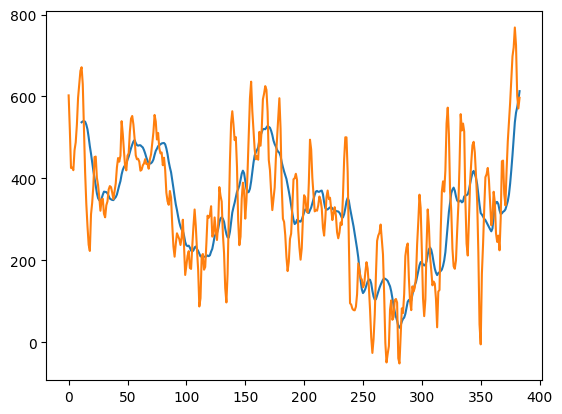

In [47]:
plt.plot(testing)
plt.plot(HF_VHF_2)

9. explore visualizations of VHF

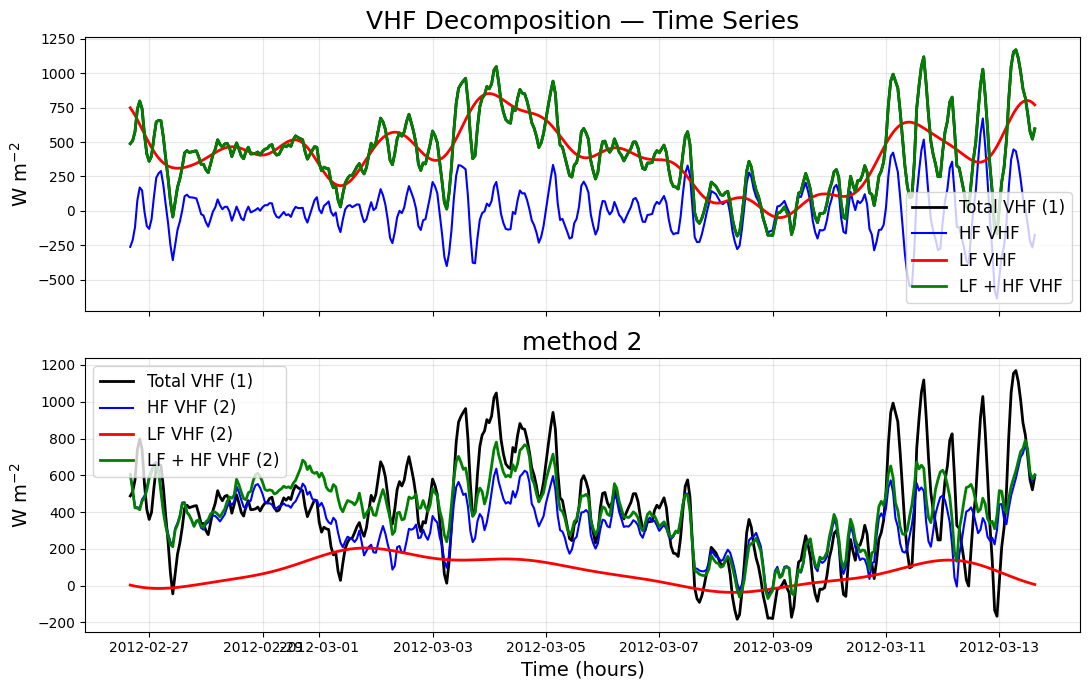

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

# -----------------------------
# Top panel: no window
# -----------------------------
axs[0].plot(VHF_total.time, VHF_total, color="black",
            label="Total VHF (1)", linewidth=2)
axs[0].plot(HF_VHF_1.time, HF_VHF_1, color="blue",
            label="HF VHF", linewidth=1.5)
axs[0].plot(LF_VHF_1.time, LF_VHF_1, color="red",
            label="LF VHF", linewidth=2)
axs[0].plot(LF_VHF_1.time, LF_VHF_1 + HF_VHF_1, color="green",
            label="LF + HF VHF", linewidth=2)

axs[0].set_title("VHF Decomposition — Time Series", fontsize=18)
axs[0].set_ylabel("W m$^{-2}$", fontsize=14)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=12)

# -----------------------------
# # Bottom panel: Method 2
# # -----------------------------
axs[1].plot(VHF_total_2.time, VHF_total_2, color="black",
            label="Total VHF (1)", linewidth=2)
axs[1].plot(HF_VHF_2.time, HF_VHF_2, color="blue",
            label="HF VHF (2)", linewidth=1.5)
axs[1].plot(LF_VHF_2.time, LF_VHF_2, color="red",
            label="LF VHF (2)", linewidth=2)
axs[1].plot(VHF_total_2.time,
            VHF_total_sum,
            color="green", label="LF + HF VHF (2)", linewidth=2)

axs[1].set_title("method 2", fontsize=18)
axs[1].set_xlabel("Time (hours)", fontsize=14)
axs[1].set_ylabel("W m$^{-2}$", fontsize=14)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

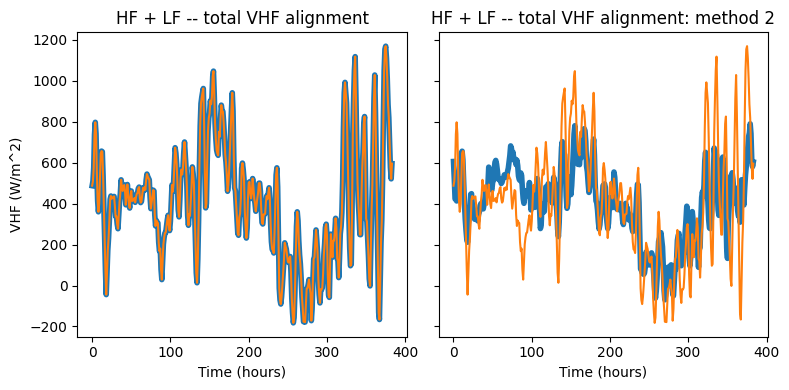

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs[0].plot(LF_VHF + HF_VHF, linewidth = 4)
axs[0].plot(VHF_total)
axs[0].set_title('HF + LF -- total VHF alignment')
axs[0].set_xlabel('Time (hours)')
axs[0].set_ylabel('VHF (W/m^2)')

axs[1].plot(VHF_total_sum, linewidth = 4)
axs[1].plot(VHF_total_2)
# axs[1].axvline(x=(len(VHF_total)/2)-(len(VHF_total)/8),c='r')
# axs[1].axvline(x=(len(VHF_total)/2)+(len(VHF_total)/8),c='r')
axs[1].set_title('HF + LF -- total VHF alignment: method 2')
axs[1].set_xlabel('Time (hours)')
plt.tight_layout()
plt.show()

NameError: name 'xr' is not defined

### NOTES 12/17/25 -- overlapping hannning windows in time -> apply calculations -> cut edges off. stitch together centered slices. See if size of window is larger than low freq modes-- add low + high to see if it is close to total-- temporal slice for testing in march.
### LF + HF != total currently, take a look at the code to determine why

### Think about where decomp should occur. take fft of bar(WT), bar(W), and bar(T) OR take fft of W and T fields OR take of final product bar(W'T') = bar(WT) - bar(W) * bar(T)

### Goals for break: 1. try to get emulator to process LLC data 2. get somewhere meaningful with VHF diagnostic 3. another diagnostic(???)